# 2. Análisis de Similitud de Productos 

El segundo script se centra en el análisis de similitud entre productos. El script utiliza algoritmos simples para calcular la proximidad entre diferentes ítems, permitiendo una mejor comprensión de las relaciones entre productos, con el fin de facilitar recomendaciones personalizadas y agrupamiento eficiente de inventario.

### Nota:

Si bien hay muchas implementaciones a lo largo de estos desafíos que pueden ser funciones, se presenta redundancia de código como forma de representar una cadena de pensamiento.

- ## Dependencias.

In [122]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
from unidecode import unidecode
from sklearn.preprocessing import normalize
from ydata_profiling import ProfileReport
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

- ## Configuraciones.

In [55]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", None)
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
nlp = spacy.load("pt_core_news_sm")
%matplotlib inline

[nltk_data] Downloading package punkt to /home/marcelo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/marcelo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /home/marcelo/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


- ## Pipeline.

In [70]:
df = pd.read_csv('items_titles.csv')
print(df.shape)
display(df)

(30000, 1)


,ITE_ITEM_TITLE
0,Tênis Ascension Posh Masculino - Preto E Vermelho
1,Tenis Para Caminhada Super Levinho Spider Corrida
2,Tênis Feminino Le Parc Hocks Black/ice Original Envio Já
3,Tênis Olympikus Esportivo Academia Nova Tendência Triunfo
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve
...,...
29995,Tênis Vans Old Skool I Love My Vans - Usado - Feminino
29996,Tênis Feminino Preto Moleca 5296155
29997,Tenis Botinha Com Pelo Via Marte Original Lançamento
29998,Tênis Slip On Feminino Masculino Original Sapato Xadrez Mule


Se evidencia no solo una falta de estandarización de los productos, sino tambien faltas de ortografía y sinónimos.

- ### EDA

In [4]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Se corrobora que no existan nulos.

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ITE_ITEM_TITLE  30000 non-null  object
dtypes: object(1)
memory usage: 234.5+ KB


La idea principal será probar distintos pipelines de preprocesamiento de los productos, de modo tal de obtener sus características principales y poder clusterizar los productos de la mejor manera posible. 

Se tendrá en cuenta como hipótesis que a la hora de realizar recomendaciones por parte de Mercadolibre, se intentan recomendar productos similares, no necesariamente de la misma marca o exactamente del mismo tipo.

Respecto a nivel inventario, se desconoce la granularidad con la cual se realiza. Si es a nivel marca te "tenis" por ejemplo, o se agrupan la cantidad de tenis independientemente de la marca y tipo. Se tratará de ver cuales son los agrupamientos posibles, y ver si los géneros o tipos de uso son agrupables

- ### Preprocesamiento.

In [72]:
sample_df = df.sample(n=100, random_state=42)  # Muestra aleatoria de 100 productos.
sample_df

,ITE_ITEM_TITLE
2308,Kit 10 Tênis Flatform
22404,Bicicleta Tsw Hurry 2020/2021 - Shimano 22v
23397,Sapatênis Sapato Ranster Sola Borracha Várias Cores
25058,Tênis Casual Feminino Tecido Slip Calça Fácil Stiletto N° 34
2664,Tenis Beira Rio 08/2021 4276103 Bege
...,...
8892,Tênis Olympikus Masculino Proof 2 Preto Faculdade Original
4461,Tênis Masculino Academia Confortavel Barato Pra Malhar
25229,Tênis Bordado Valentina Preto
29985,Mizuno Wave Prophecy Hajime Sorayama


In [25]:
sample_list = list(sample_df['ITE_ITEM_TITLE'])

In [32]:
filter_1 = []
for sample in sample_list:
    filter_1.append(sample.lower())
filter_1

['kit  10 tênis flatform ',
 'bicicleta tsw hurry 2020/2021 - shimano 22v',
 'sapatênis sapato ranster sola borracha várias cores',
 'tênis casual feminino tecido slip calça fácil stiletto n° 34',
 'tenis beira rio 08/2021 4276103 bege',
 'tenis feminino vizzano sapatenis plataforma casual',
 'sapatos esportivos feminino rumba waltz prom ballroom dança',
 'tênis botinha sneakers feminino',
 'mountain bike caloi explorer sport 2021 aro 29 24 v. suntour',
 'tênis usthemp volare temá\x81tico - olly',
 'sapatênis feminino tênis branco estrela dourada lançamento',
 'bicicleta bike aro 24 top brave tz shimano 21 velocidades',
 'tênis infantil panda',
 'tênis fila revelation masculino',
 'tênis barato',
 'sneaker tenis feminino  flatforme azillê bege com pedras',
 'tenis casual 01',
 'bicicleta scott scale 930 carbon 2015',
 '2 pares do calçado shox 4 molas nz masculino promoção top',
 'tênis sereia paetê infantil lantejoula magica lilás 25/36',
 'puma infantil animals panda',
 'tênis infanti

Quitemos catacteres que son propios del idioma para mejorar el agrupamiento.

In [34]:
filter_1_2 = []
for sample in filter_1:
    filter_1_2.append(unidecode(sample))
filter_1_2

['kit  10 tenis flatform ',
 'bicicleta tsw hurry 2020/2021 - shimano 22v',
 'sapatenis sapato ranster sola borracha varias cores',
 'tenis casual feminino tecido slip calca facil stiletto ndeg 34',
 'tenis beira rio 08/2021 4276103 bege',
 'tenis feminino vizzano sapatenis plataforma casual',
 'sapatos esportivos feminino rumba waltz prom ballroom danca',
 'tenis botinha sneakers feminino',
 'mountain bike caloi explorer sport 2021 aro 29 24 v. suntour',
 'tenis usthemp volare tematico - olly',
 'sapatenis feminino tenis branco estrela dourada lancamento',
 'bicicleta bike aro 24 top brave tz shimano 21 velocidades',
 'tenis infantil panda',
 'tenis fila revelation masculino',
 'tenis barato',
 'sneaker tenis feminino  flatforme azille bege com pedras',
 'tenis casual 01',
 'bicicleta scott scale 930 carbon 2015',
 '2 pares do calcado shox 4 molas nz masculino promocao top',
 'tenis sereia paete infantil lantejoula magica lilas 25/36',
 'puma infantil animals panda',
 'tenis infantil 

Tokenizemos.

In [46]:
filter_1_2_3 = []
for sample in filter_1_2:
     filter_1_2_3.append(word_tokenize(sample, language='portuguese'))
filter_1_2_3

[['kit', '10', 'tenis', 'flatform'],
 ['bicicleta', 'tsw', 'hurry', '2020/2021', '-', 'shimano', '22v'],
 ['sapatenis', 'sapato', 'ranster', 'sola', 'borracha', 'varias', 'cores'],
 ['tenis',
  'casual',
  'feminino',
  'tecido',
  'slip',
  'calca',
  'facil',
  'stiletto',
  'ndeg',
  '34'],
 ['tenis', 'beira', 'rio', '08/2021', '4276103', 'bege'],
 ['tenis', 'feminino', 'vizzano', 'sapatenis', 'plataforma', 'casual'],
 ['sapatos',
  'esportivos',
  'feminino',
  'rumba',
  'waltz',
  'prom',
  'ballroom',
  'danca'],
 ['tenis', 'botinha', 'sneakers', 'feminino'],
 ['mountain',
  'bike',
  'caloi',
  'explorer',
  'sport',
  '2021',
  'aro',
  '29',
  '24',
  'v.',
  'suntour'],
 ['tenis', 'usthemp', 'volare', 'tematico', '-', 'olly'],
 ['sapatenis',
  'feminino',
  'tenis',
  'branco',
  'estrela',
  'dourada',
  'lancamento'],
 ['bicicleta',
  'bike',
  'aro',
  '24',
  'top',
  'brave',
  'tz',
  'shimano',
  '21',
  'velocidades'],
 ['tenis', 'infantil', 'panda'],
 ['tenis', 'fil

Eliminemos los caracteres que no sean palabras. Los números generan mucha varianza ya que aparecen en distintos contextos.

In [53]:
filter_1_2_3_4 = [] 
for sample in filter_1_2_3:
        filter_1_2_3_4.append([word for word in sample if word.isalpha()])
filter_1_2_3_4

[['kit', 'tenis', 'flatform'],
 ['bicicleta', 'tsw', 'hurry', 'shimano'],
 ['sapatenis', 'sapato', 'ranster', 'sola', 'borracha', 'varias', 'cores'],
 ['tenis',
  'casual',
  'feminino',
  'tecido',
  'slip',
  'calca',
  'facil',
  'stiletto',
  'ndeg'],
 ['tenis', 'beira', 'rio', 'bege'],
 ['tenis', 'feminino', 'vizzano', 'sapatenis', 'plataforma', 'casual'],
 ['sapatos',
  'esportivos',
  'feminino',
  'rumba',
  'waltz',
  'prom',
  'ballroom',
  'danca'],
 ['tenis', 'botinha', 'sneakers', 'feminino'],
 ['mountain', 'bike', 'caloi', 'explorer', 'sport', 'aro', 'suntour'],
 ['tenis', 'usthemp', 'volare', 'tematico', 'olly'],
 ['sapatenis',
  'feminino',
  'tenis',
  'branco',
  'estrela',
  'dourada',
  'lancamento'],
 ['bicicleta', 'bike', 'aro', 'top', 'brave', 'tz', 'shimano', 'velocidades'],
 ['tenis', 'infantil', 'panda'],
 ['tenis', 'fila', 'revelation', 'masculino'],
 ['tenis', 'barato'],
 ['sneaker',
  'tenis',
  'feminino',
  'flatforme',
  'azille',
  'bege',
  'com',
  'p

Probemos ver como queda stemización. Quizás no es es necesaria y probaremos un pipeline sin ella. Primero quitemos stopwords.

In [64]:
lematizador = RSLPStemmer()
for sample in filter_1_2_3_4:
    lemas = [lematizador.stem(word) for word in sample if word not in STOP_WORDS]
    print(lemas)

['kit', 'tenil', 'flatform']
['biciclet', 'tsw', 'hurry', 'shim']
['sapatenil', 'sapat', 'ranst', 'sol', 'borrach', 'var', 'cor']
['tenil', 'cas', 'feminin', 'tec', 'slip', 'calc', 'facil', 'stilett', 'ndeg']
['tenil', 'beir', 'rio', 'beg']
['tenil', 'feminin', 'vizz', 'sapatenil', 'plataform', 'cas']
['sapat', 'espor', 'feminin', 'rumb', 'waltz', 'prom', 'ballroom', 'danc']
['tenil', 'bot', 'sneak', 'feminin']
['mountain', 'bik', 'calo', 'explor', 'sport', 'aro', 'suntour']
['tenil', 'usthemp', 'vol', 'tema', 'olly']
['sapatenil', 'feminin', 'tenil', 'branc', 'estrel', 'dour', 'lanc']
['biciclet', 'bik', 'aro', 'top', 'brav', 'tz', 'shim', 'veloc']
['tenil', 'infantil', 'pand']
['tenil', 'fil', 'revelation', 'masculin']
['tenil', 'barat']
['sneak', 'tenil', 'feminin', 'flatform', 'azill', 'beg', 'pedr']
['tenil', 'cas']
['biciclet', 'scott', 'scal', 'carbon']
['par', 'calc', 'shox', 'mol', 'nz', 'masculin', 'promoca', 'top']
['tenil', 'sere', 'paet', 'infantil', 'lantejoul', 'magic', 

In [66]:
for sample in filter_1_2_3_4:
    for word in sample:
        if word in STOP_WORDS:
            print(word)

com
do
usa
e
com
e
para
para
de
de
de
de
em
de
das
com
e
de
e
pelo
com
de
sua
todo
com


In [74]:
def preprocessing(text):
    text = text.lower()
    text = unidecode(text)
    tokens = word_tokenize(text, language='portuguese')
    tokens = [lematizador.stem(token) for token in tokens if token.isalpha() and token not in STOP_WORDS]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

Quito algunas. Probemos con nuestro pipeline hasta ahora.

- ### TFID vectorizer más Kmeans con distancia coseno.

Veamos primero cual debería ser el número óptimo de clusteres, utilizando el "elbow method" y el sample_df.

In [73]:
sample_df.columns

Index(['ITE_ITEM_TITLE'], dtype='object')

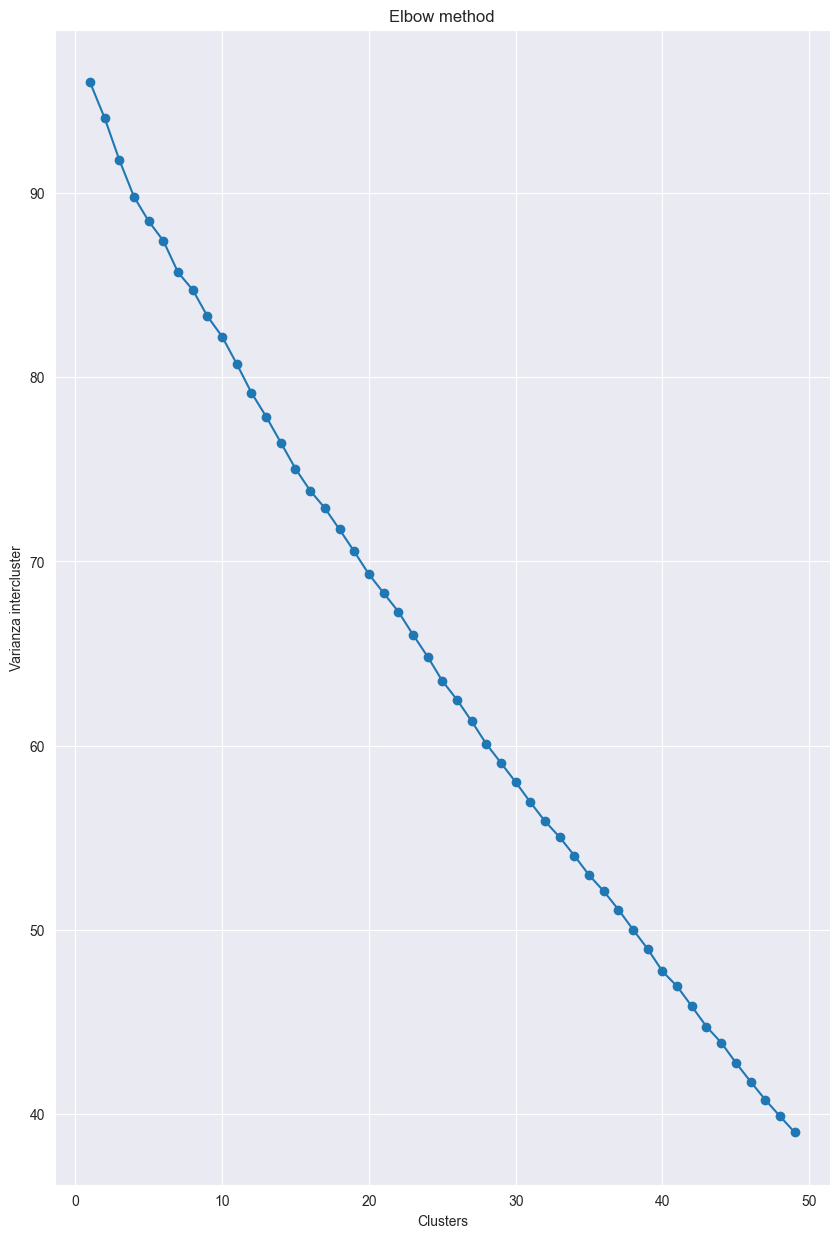

In [123]:
lematizador = RSLPStemmer()

sample_df['item_preprocesado'] = sample_df['ITE_ITEM_TITLE'].apply(preprocessing)

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(sample_df['item_preprocesado'])

tfidf_matrix = normalize(tfidf_matrix) # Normalizo para que Kmeans reemplace la distancia euclídea por la distancia coseno.


varianzas = []
rangos_clusters = range(1, 50)

for num_clusters in rangos_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)
    varianzas.append(kmeans.inertia_)

plt.figure(figsize=(10, 15))
plt.plot(rangos_clusters, varianzas, marker='o')
plt.title('Elbow method')
plt.xlabel('Clusters')
plt.ylabel('Varianza intercluster')
plt.show()

No está muy claro, pero podríamos decir que el 7 es aquel en donde la derivada disminuye. Probemos.

In [124]:
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
sample_df['cluster'] = kmeans.fit_predict(tfidf_matrix)

In [125]:
for cluster in range(num_clusters):
    display(sample_df[sample_df['cluster'] == cluster])

,ITE_ITEM_TITLE,item_preprocesado,cluster
11311,Mountain Bike Caloi Explorer Sport 2021 Aro 29 24 V. Suntour,mountain bik calo explor sport aro suntour,0
9482,Slip On Bonequinha Fashion - Nude,slip on bonec fashion nud,0
10092,Tênis Feminino Snearker Tratorado Ramarim - 20-75205,tenil feminin sneark trator ramarim,0
22567,Sapato De Corrida,sapat corr,0
14905,Tv LG 43uh6100 Tela Quebrada,tv lg tel quebr,0
20604,Mini Melissa Street Kids Azul,min meliss street kid azul,0
12335,Kobe 6 Proto Grinch,kob prot grinch,0
6332,Bike Caloi Team Carbono 2018,bik calo te carbon,0
29985,Mizuno Wave Prophecy Hajime Sorayama,mizun wav prophecy hajim sorayam,0


,ITE_ITEM_TITLE,item_preprocesado,cluster
15947,Tênis Fila Revelation Masculino,tenil fil revelation masculin,1
26545,2 Pares Do Calçado Shox 4 Molas Nz Masculino Promoção Top,par calc shox mol nz masculin promoca top,1
3673,Tênis Feminino Old Skool Preto Black Friday,tenil feminin old skool pret black friday,1
29271,Tenis Olympikus Iris Marinho,tenil olympiku iril mar,1
21457,Tênis Masculino Lincy Im004,tenil masculin lincy,1
7337,Tenis Mizuno Esportivo De Academia/corrida Hawk 3 Original,tenil mizun espor hawk orig,1
24483,Tenis New Balance 515 Classic Masculino Preto Ml515br3,tenil new balanc classic masculin pret,1
8223,Combo 3 Pares De Tênis Masculino Zip Nik Corrida Esportivo,comb par tenil masculin zip nik corr espor,1
2868,Tenis Melissa Ulitsa Sneaker 32338 - Original - Dia Das Mães,tenil meliss ulits sneak orig dia mae,1
8832,Tênis De Skate Mad Rats Hi Top Pu Branco Azul Original Nfe,tenil skat mad rat hi top pu branc azul orig nfe,1


,ITE_ITEM_TITLE,item_preprocesado,cluster
23397,Sapatênis Sapato Ranster Sola Borracha Várias Cores,sapatenil sapat ranst sol borrach var cor,2
25058,Tênis Casual Feminino Tecido Slip Calça Fácil Stiletto N° 34,tenil cas feminin tec slip calc facil stilett ndeg,2
8511,Tenis Feminino Vizzano Sapatenis Plataforma Casual,tenil feminin vizz sapatenil plataform cas,2
5148,Sapatos Esportivos Feminino Rumba Waltz Prom Ballroom Dança,sapat espor feminin rumb waltz prom ballroom danc,2
7790,Tênis Botinha Sneakers Feminino,tenil bot sneak feminin,2
10784,Sapatênis Feminino Tênis Branco Estrela Dourada Lançamento,sapatenil feminin tenil branc estrel dour lanc,2
14474,Sneaker Tenis Feminino Flatforme Azillê Bege Com Pedras,sneak tenil feminin flatform azill beg pedr,2
28694,Tenis Casual 01,tenil cas,2
15107,Tênis Fila Forehand Feminino - Marinho E Salmão,tenil fil forehand feminin mar salma,2
21388,Tênis Feminino Botinha Kolosh Com Amortecedor Hades C1295,tenil feminin bot kolosh amortec had,2


,ITE_ITEM_TITLE,item_preprocesado,cluster
3268,Tênis Infantil Panda,tenil infantil pand,3
14980,Tênis Sereia Paetê Infantil Lantejoula Magica Lilás 25/36,tenil sere paet infantil lantejoul magic lil,3
17636,Puma Infantil Animals Panda,pum infantil animal pand,3
3931,Tênis Infantil adidas Tamanho 25 Br,tenil infantil adid tamanh br,3
8028,Promoção Tenis Infantil Feminino Unicórnio,promoca tenil infantil feminin unicorni,3
5937,Bicicleta Aro 20 Bicolor Menino Ultra Bikes Infantil,biciclet aro bicol menin ultr bik infantil,3
9350,Tênis Infantil Masculino Now United,tenil infantil masculin now united,3
10982,Tenis Infantil Vulcanizado Starzinho 3003.0003,tenil infantil vulcan st,3
19367,Tênis Infantil Meia Mario Calce Fácil Personagem Meninos,tenil infantil mei mari calc facil person menin,3


,ITE_ITEM_TITLE,item_preprocesado,cluster
22404,Bicicleta Tsw Hurry 2020/2021 - Shimano 22v,biciclet tsw hurry shim,4
22246,Bicicleta Bike Aro 24 Top Brave Tz Shimano 21 Velocidades,biciclet bik aro top brav tz shim veloc,4
14054,Bicicleta Scott Scale 930 Carbon 2015,biciclet scott scal carbon,4
21880,Bicicleta Mountain Bike Sense One 2021/22 Aro 29 M 21v C/ Nf,biciclet mountain bik sens one aro m nf,4
27012,Bicicleta Mtb Havok Sx 2021,biciclet mtb havok sx,4
2342,Bicicleta Aro 29 Alumínio Preto Fosco Com Vermelho E Azul,biciclet aro alumini pret fosc vermelh azul,4
16557,Bicicleta Mtb Aro 29 Quadro 21 Alumínio 27 Marchas Freio Hid,biciclet mtb aro quadr alumini march frei hid,4
27387,Sapatilha Tsw Mtb Smart U2 Preta,sapatilh tsw mtb smart pret,4
11356,Bicicleta Feminina Bkl Forendy Aro 29 Shimano Tourney 21v,biciclet feminin bkl forendy aro shim tourney,4
20747,Bicicleta Mtb Aro 29 Kode Izon Cinza Verde 24v Shimano,biciclet mtb aro kod izon cinz verd shim,4


,ITE_ITEM_TITLE,item_preprocesado,cluster
8387,Asics Metarun Importado Usa Original,asic metarun import orig,5


,ITE_ITEM_TITLE,item_preprocesado,cluster
2308,Kit 10 Tênis Flatform,kit tenil flatform,6
2664,Tenis Beira Rio 08/2021 4276103 Bege,tenil beir rio beg,6
19043,Tênis Usthemp Volare Temático - Olly,tenil usthemp vol tema olly,6
14977,Tênis Barato,tenil barat,6
22572,Tênis One Piece Versão Limitada Barba Branca Cano Alto,tenil one piec versa limit barb branc can alt,6
6508,Calzado Ligero Pará Caminar Pará Hombre Tenis Deportivo,calz liger camin hombr tenil depor,6
12976,Tênis Super Resistente Bico De Aço Bota Antiderrapante Leve,tenil sup resist bic aco bot antiderrap lev,6
3813,Tênis Xadrez Classic Pronta Entrega Frete Grátis,tenil xadr classic pront entreg fret gratil,6
12983,Tênis Pêlo Imitação Girafa,tenil imitaca giraf,6
3014,Tênis Pampili Slipon Led - Rosa,tenil pampil slipon led ros,6


Hay categorías mezcladas. Veamos si podemos buscar otro método para optimizar los clusteres.

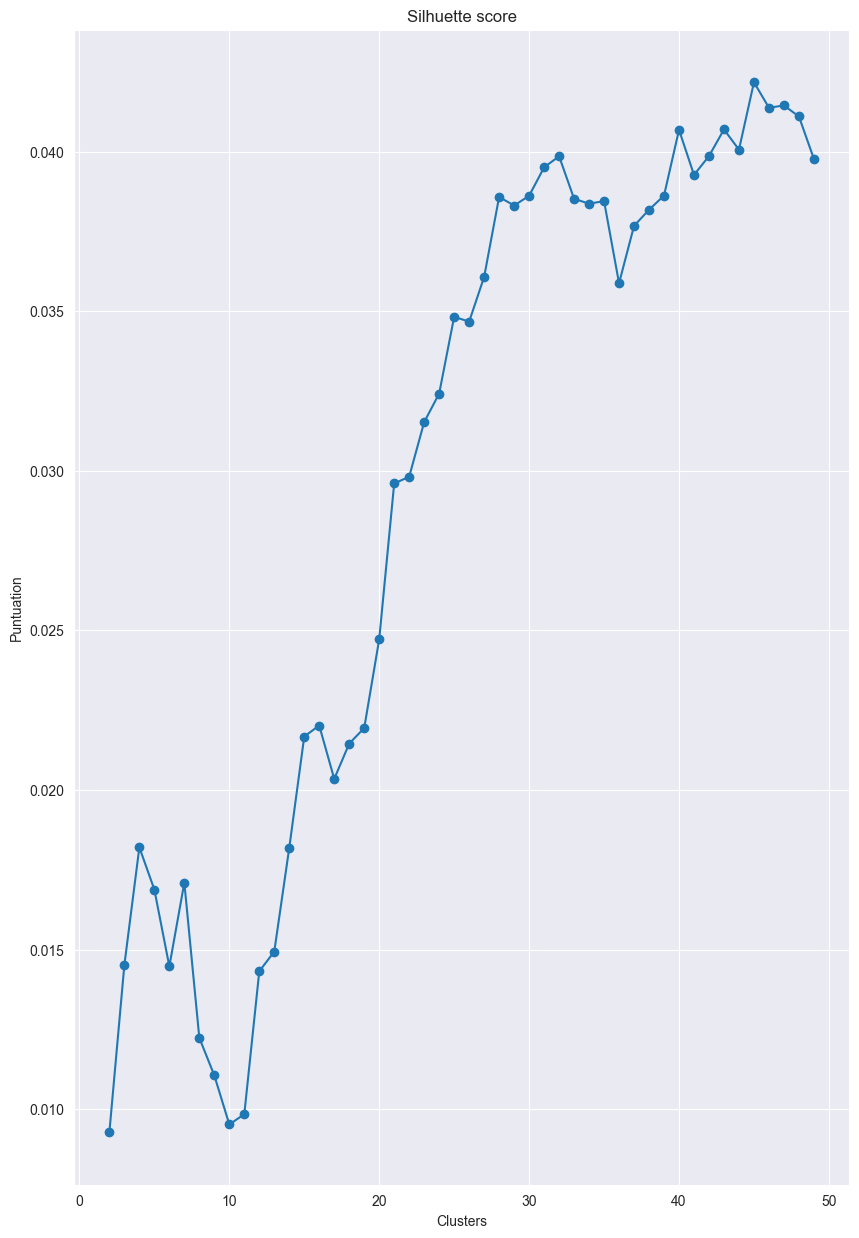

In [126]:
silhouette_scores = []

rangos_clusters = range(2, 50)
for num_clusters in rangos_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(tfidf_matrix, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 15))
plt.plot(rangos_clusters, silhouette_scores, marker='o')
plt.title('Silhuette score')
plt.xlabel('Clusters')
plt.ylabel('Puntuation')
plt.show()

El número ideal sería 45. Probemos

In [127]:
num_clusters = 45
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
sample_df['cluster'] = kmeans.fit_predict(tfidf_matrix)

In [128]:
for cluster in range(num_clusters):
    display(sample_df[sample_df['cluster'] == cluster])

,ITE_ITEM_TITLE,item_preprocesado,cluster
10092,Tênis Feminino Snearker Tratorado Ramarim - 20-75205,tenil feminin sneark trator ramarim,0


,ITE_ITEM_TITLE,item_preprocesado,cluster
29271,Tenis Olympikus Iris Marinho,tenil olympiku iril mar,1
24483,Tenis New Balance 515 Classic Masculino Preto Ml515br3,tenil new balanc classic masculin pret,1
9419,Tênis Olympikus Bravo Vermelho Com Preto Masculino,tenil olympiku brav vermelh pret masculin,1
8892,Tênis Olympikus Masculino Proof 2 Preto Faculdade Original,tenil olympiku masculin proof pret faculdad orig,1


,ITE_ITEM_TITLE,item_preprocesado,cluster
8511,Tenis Feminino Vizzano Sapatenis Plataforma Casual,tenil feminin vizz sapatenil plataform cas,2
10784,Sapatênis Feminino Tênis Branco Estrela Dourada Lançamento,sapatenil feminin tenil branc estrel dour lanc,2
19592,Tênis Feminino Vizzano 1214.205 Em Promoção,tenil feminin vizz promoca,2
7932,Tenis Plataforma Feminino Blogueira Nude Número 34 E 35,tenil plataform feminin blogu nud numer,2


,ITE_ITEM_TITLE,item_preprocesado,cluster
3931,Tênis Infantil adidas Tamanho 25 Br,tenil infantil adid tamanh br,3
5081,Tênis adidas Response Super Marinho/branco,tenil adid respons sup,3


,ITE_ITEM_TITLE,item_preprocesado,cluster
5937,Bicicleta Aro 20 Bicolor Menino Ultra Bikes Infantil,biciclet aro bicol menin ultr bik infantil,4
9585,Tênis Skechers Masculino Go Walk Evolution Ultra,tenil skech masculin go walk evolution ultr,4
19367,Tênis Infantil Meia Mario Calce Fácil Personagem Meninos,tenil infantil mei mari calc facil person menin,4


,ITE_ITEM_TITLE,item_preprocesado,cluster
14977,Tênis Barato,tenil barat,5
4461,Tênis Masculino Academia Confortavel Barato Pra Malhar,tenil masculin academ conforta barat pra malh,5


,ITE_ITEM_TITLE,item_preprocesado,cluster
2664,Tenis Beira Rio 08/2021 4276103 Bege,tenil beir rio beg,6


,ITE_ITEM_TITLE,item_preprocesado,cluster
7790,Tênis Botinha Sneakers Feminino,tenil bot sneak feminin,7
14474,Sneaker Tenis Feminino Flatforme Azillê Bege Com Pedras,sneak tenil feminin flatform azill beg pedr,7
21388,Tênis Feminino Botinha Kolosh Com Amortecedor Hades C1295,tenil feminin bot kolosh amortec had,7
12976,Tênis Super Resistente Bico De Aço Bota Antiderrapante Leve,tenil sup resist bic aco bot antiderrap lev,7
2868,Tenis Melissa Ulitsa Sneaker 32338 - Original - Dia Das Mães,tenil meliss ulits sneak orig dia mae,7
25535,Tênis Feminino Sneaker Solado Branco Linha Confort Luxo,tenil feminin sneak sol branc linh confort lux,7
15878,Tênis Redley Feminino,tenil redley feminin,7
12606,Tênis Sneaker Solado Chunky Feminino Branco Original | Dubuy,tenil sneak sol chunky feminin branc orig dubuy,7


,ITE_ITEM_TITLE,item_preprocesado,cluster
22404,Bicicleta Tsw Hurry 2020/2021 - Shimano 22v,biciclet tsw hurry shim,8
22246,Bicicleta Bike Aro 24 Top Brave Tz Shimano 21 Velocidades,biciclet bik aro top brav tz shim veloc,8
11356,Bicicleta Feminina Bkl Forendy Aro 29 Shimano Tourney 21v,biciclet feminin bkl forendy aro shim tourney,8
20747,Bicicleta Mtb Aro 29 Kode Izon Cinza Verde 24v Shimano,biciclet mtb aro kod izon cinz verd shim,8


,ITE_ITEM_TITLE,item_preprocesado,cluster
8832,Tênis De Skate Mad Rats Hi Top Pu Branco Azul Original Nfe,tenil skat mad rat hi top pu branc azul orig nfe,9
821,Tênis Mizuno Wave Prophecy 8 Verde/grafite 43 Lindo Top,tenil mizun wav prophecy lind top,9
29985,Mizuno Wave Prophecy Hajime Sorayama,mizun wav prophecy hajim sorayam,9


,ITE_ITEM_TITLE,item_preprocesado,cluster
2308,Kit 10 Tênis Flatform,kit tenil flatform,10
26545,2 Pares Do Calçado Shox 4 Molas Nz Masculino Promoção Top,par calc shox mol nz masculin promoca top,10
8028,Promoção Tenis Infantil Feminino Unicórnio,promoca tenil infantil feminin unicorni,10
20071,Kit 4 Pares De Tênis Feminino Confortavel Promoção Sapatenis,kit par tenil feminin conforta promoca sapatenil,10
23189,Tênis Polo Open (consulta Cores) Kit 3un,tenil pol open consult cor kit,10


,ITE_ITEM_TITLE,item_preprocesado,cluster
21457,Tênis Masculino Lincy Im004,tenil masculin lincy,11
8223,Combo 3 Pares De Tênis Masculino Zip Nik Corrida Esportivo,comb par tenil masculin zip nik corr espor,11
27331,Tênis Nike Air Rock Raider Original Número 37,tenil nik air rock raid orig numer,11
17963,Tênis Masculino Dooze Mollas Lançamento Envio Rapido Free,tenil masculin dooz moll lanc envi rap fre,11
20497,Tênis Nike Winflo 8 Masculino,tenil nik winfl masculin,11


,ITE_ITEM_TITLE,item_preprocesado,cluster
5148,Sapatos Esportivos Feminino Rumba Waltz Prom Ballroom Dança,sapat espor feminin rumb waltz prom ballroom danc,12


,ITE_ITEM_TITLE,item_preprocesado,cluster
11311,Mountain Bike Caloi Explorer Sport 2021 Aro 29 24 V. Suntour,mountain bik calo explor sport aro suntour,13
22572,Tênis One Piece Versão Limitada Barba Branca Cano Alto,tenil one piec versa limit barb branc can alt,13
21880,Bicicleta Mountain Bike Sense One 2021/22 Aro 29 M 21v C/ Nf,biciclet mountain bik sens one aro m nf,13


,ITE_ITEM_TITLE,item_preprocesado,cluster
19992,Tênis Moleca Iati Slipper On Feminino Todo Riscado Original,tenil molec iat slipp on feminin risc orig,14


,ITE_ITEM_TITLE,item_preprocesado,cluster
9482,Slip On Bonequinha Fashion - Nude,slip on bonec fashion nud,15
13375,Tênis Slip On Petite Jolie Verniz Lupita Pj5443,tenil slip on petit joli verniz lupit,15


,ITE_ITEM_TITLE,item_preprocesado,cluster
25058,Tênis Casual Feminino Tecido Slip Calça Fácil Stiletto N° 34,tenil cas feminin tec slip calc facil stilett ndeg,16
28694,Tenis Casual 01,tenil cas,16
27033,Sapatos Casuais Elegantes São Respiráveis E Leves,sapat cas eleg sao respira lev,16
5121,Tênis Casual Infantil Meninos Botinho Palmilha Macia Preto,tenil cas infantil menin bot palmilh mac pret,16
3752,Tênis Casual Feminino Branco Flatform Corda Promoção,tenil cas feminin branc flatform cord promoca,16
29612,Tênis Feminino Casual Kolosh Hades C1294 Conforto Original,tenil feminin cas kolosh had confort orig,16


,ITE_ITEM_TITLE,item_preprocesado,cluster
29995,Tênis Vans Old Skool I Love My Vans - Usado - Feminino,tenil vam old skool i lov my vam us feminin,17


,ITE_ITEM_TITLE,item_preprocesado,cluster
2676,Tênis Masculino Christian Fischer Couro Preto Design Moderno,tenil masculin christian fisch cour pret design modern,18
18079,Sapatenis Iate Masculino De Couro Pegada Confortável,sapatenil iat masculin cour peg conforta,18
13235,Sapatênis Masculino Zipper Couro Pegada 114852,sapatenil masculin zipp cour peg,18


,ITE_ITEM_TITLE,item_preprocesado,cluster
20604,Mini Melissa Street Kids Azul,min meliss street kid azul,19
747,Tênis Holográfico Mini Sua Cia,tenil holograf min cia,19


,ITE_ITEM_TITLE,item_preprocesado,cluster
15947,Tênis Fila Revelation Masculino,tenil fil revelation masculin,20
15107,Tênis Fila Forehand Feminino - Marinho E Salmão,tenil fil forehand feminin mar salma,20


,ITE_ITEM_TITLE,item_preprocesado,cluster
3014,Tênis Pampili Slipon Led - Rosa,tenil pampil slipon led ros,21


,ITE_ITEM_TITLE,item_preprocesado,cluster
3673,Tênis Feminino Old Skool Preto Black Friday,tenil feminin old skool pret black friday,22


,ITE_ITEM_TITLE,item_preprocesado,cluster
3268,Tênis Infantil Panda,tenil infantil pand,23
17636,Puma Infantil Animals Panda,pum infantil animal pand,23


,ITE_ITEM_TITLE,item_preprocesado,cluster
27012,Bicicleta Mtb Havok Sx 2021,biciclet mtb havok sx,24
27387,Sapatilha Tsw Mtb Smart U2 Preta,sapatilh tsw mtb smart pret,24
11544,Sapatilha Ciclismo Mtb Grool Cool Velcro Preto Tam. 44 Br,sapatilh cicl mtb grool cool velcr pret tam br,24


,ITE_ITEM_TITLE,item_preprocesado,cluster
3813,Tênis Xadrez Classic Pronta Entrega Frete Grátis,tenil xadr classic pront entreg fret gratil,25


,ITE_ITEM_TITLE,item_preprocesado,cluster
2342,Bicicleta Aro 29 Alumínio Preto Fosco Com Vermelho E Azul,biciclet aro alumini pret fosc vermelh azul,26
16557,Bicicleta Mtb Aro 29 Quadro 21 Alumínio 27 Marchas Freio Hid,biciclet mtb aro quadr alumini march frei hid,26


,ITE_ITEM_TITLE,item_preprocesado,cluster
14054,Bicicleta Scott Scale 930 Carbon 2015,biciclet scott scal carbon,27


,ITE_ITEM_TITLE,item_preprocesado,cluster
24429,Tênis Itachi Akatsuki Naruto Anime Customizado Cores,tenil itach akatsuk narut anim custom cor,28


,ITE_ITEM_TITLE,item_preprocesado,cluster
6508,Calzado Ligero Pará Caminar Pará Hombre Tenis Deportivo,calz liger camin hombr tenil depor,29


,ITE_ITEM_TITLE,item_preprocesado,cluster
1190,Tênis Hero 223 Preto T.antonio,tenil her pret,30
25229,Tênis Bordado Valentina Preto,tenil bord valentin pret,30


,ITE_ITEM_TITLE,item_preprocesado,cluster
12983,Tênis Pêlo Imitação Girafa,tenil imitaca giraf,31


,ITE_ITEM_TITLE,item_preprocesado,cluster
5201,Tênis Feminino Básico Via Marte Caminhada Academia Original,tenil feminin basic via mart caminh academ orig,32


,ITE_ITEM_TITLE,item_preprocesado,cluster
12335,Kobe 6 Proto Grinch,kob prot grinch,33


,ITE_ITEM_TITLE,item_preprocesado,cluster
23397,Sapatênis Sapato Ranster Sola Borracha Várias Cores,sapatenil sapat ranst sol borrach var cor,34
22567,Sapato De Corrida,sapat corr,34


,ITE_ITEM_TITLE,item_preprocesado,cluster
12124,Tenis Dg Porto All Black Unissex Diamante,tenil dg port all black unissex diam,35
28100,Tênis Urbann Boards College Leather All Black,tenil urbann board colleg leath all black,35


,ITE_ITEM_TITLE,item_preprocesado,cluster
14905,Tv LG 43uh6100 Tela Quebrada,tv lg tel quebr,36


,ITE_ITEM_TITLE,item_preprocesado,cluster
28738,Tenis Preto Com Luz Infanto Juvenil Tenis Pra Criança Macio,tenil pret luz infant juvenil tenil pra crianc maci,37
13332,Tenis Feminino Cadarco Super Confortavel Sapatilha Oficial,tenil feminin cadarc sup conforta sapatilh ofic,37
23621,Tênis Feminino Leve Estiloso Macio Confortável 4020,tenil feminin lev estil maci conforta,37


,ITE_ITEM_TITLE,item_preprocesado,cluster
25246,Tênis Versace Bege/branco Flex Bellisima,tenil versac flex bellis,38


,ITE_ITEM_TITLE,item_preprocesado,cluster
8387,Asics Metarun Importado Usa Original,asic metarun import orig,39
7337,Tenis Mizuno Esportivo De Academia/corrida Hawk 3 Original,tenil mizun espor hawk orig,39


,ITE_ITEM_TITLE,item_preprocesado,cluster
17986,Bicicleta Caloi Seminova,biciclet calo seminov,40
6332,Bike Caloi Team Carbono 2018,bik calo te carbon,40


,ITE_ITEM_TITLE,item_preprocesado,cluster
19043,Tênis Usthemp Volare Temático - Olly,tenil usthemp vol tema olly,41


,ITE_ITEM_TITLE,item_preprocesado,cluster
7885,Tenis Fem Modare 735510121885,tenil fem mod,42


,ITE_ITEM_TITLE,item_preprocesado,cluster
9760,Tênis Empório Armani Jeans Original 42/43,tenil empori arman je orig,43


,ITE_ITEM_TITLE,item_preprocesado,cluster
14980,Tênis Sereia Paetê Infantil Lantejoula Magica Lilás 25/36,tenil sere paet infantil lantejoul magic lil,44
9350,Tênis Infantil Masculino Now United,tenil infantil masculin now united,44
10982,Tenis Infantil Vulcanizado Starzinho 3003.0003,tenil infantil vulcan st,44


No está mal. Hay outliers pero generaliza bien e intenta separar bien según la descripción. Probemos con el dataset completo.

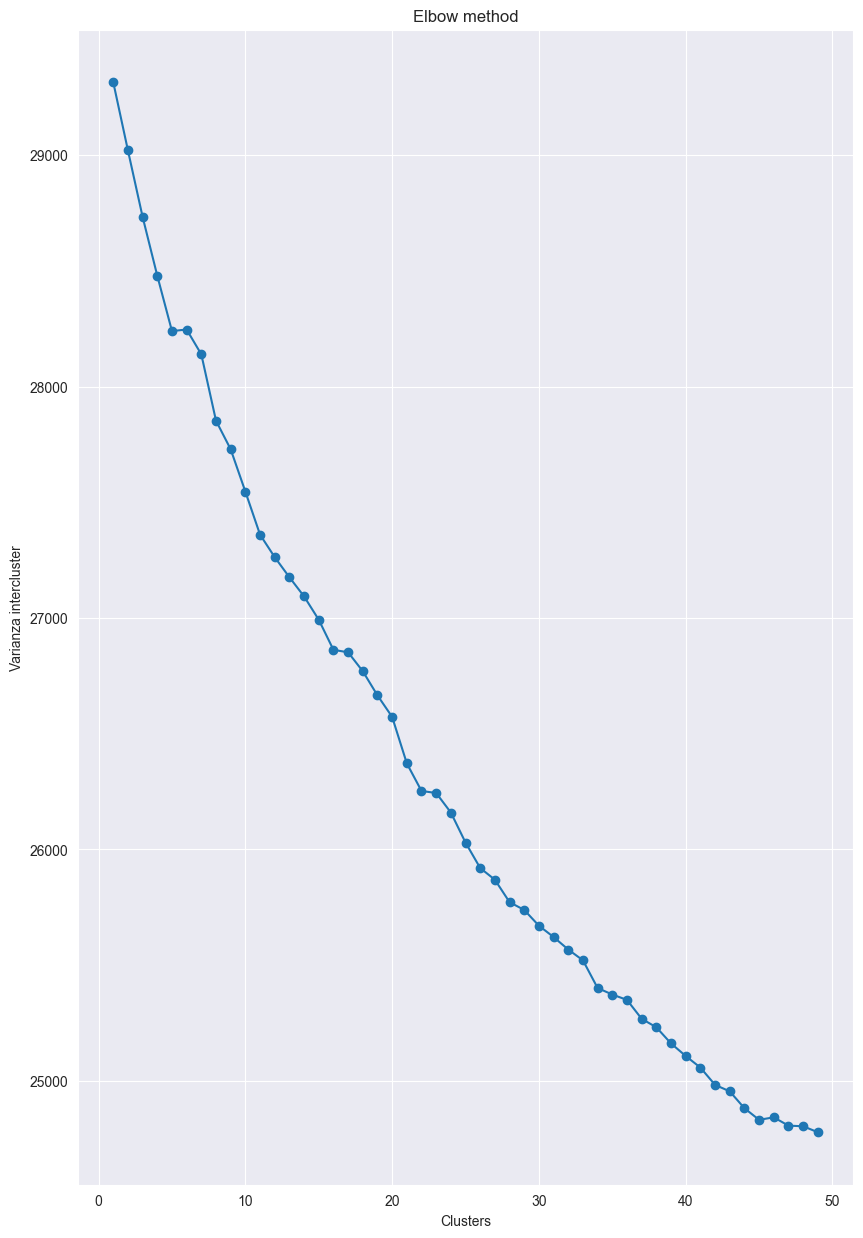

In [139]:
df['item_preprocesado'] = df['ITE_ITEM_TITLE'].apply(preprocessing)

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['item_preprocesado'])

tfidf_matrix = normalize(tfidf_matrix)

varianzas = []
rangos_clusters = range(1, 50)

for num_clusters in rangos_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)
    varianzas.append(kmeans.inertia_)

plt.figure(figsize=(10, 15))
plt.plot(rangos_clusters, varianzas, marker='o')
plt.title('Elbow method')
plt.xlabel('Clusters')
plt.ylabel('Varianza intercluster')
plt.show()

5, 16 y 22 son buenos candidatos.

In [141]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

In [142]:
for cluster in range(num_clusters):
    display(df[df['cluster'] == cluster])

,ITE_ITEM_TITLE,item_preprocesado,cluster
1,Tenis Para Caminhada Super Levinho Spider Corrida,tenil caminh sup lev spid corr,0
2,Tênis Feminino Le Parc Hocks Black/ice Original Envio Já,tenil feminin le parc hock orig envi ja,0
3,Tênis Olympikus Esportivo Academia Nova Tendência Triunfo,tenil olympiku espor academ tendenc triunf,0
7,Tv Samsung Qled 8k Q800t Semi Nova,tv samsung qled sem,0
8,Tênis Usthemp Short Temático - Maria Vira-lata 2,tenil usthemp short tema mar,0
...,...,...,...
29986,Tênis Unissex Cat Caterpillar Caminhada Corrida Eclipse 320,tenil unissex cat caterpill caminh corr eclips,0
29989,Tênis Ykes F5,tenil yke,0
29992,Tênis Nike Zoom Javelin Elite,tenil nik zoom javelin elit,0
29994,Air Force Shadow Mystic Navy,air forc shadow mystic navy,0


,ITE_ITEM_TITLE,item_preprocesado,cluster
6,Tênis Infantil Ortopasso Conforto Jogging,tenil infantil ortopass confort jogging,1
11,Sapatenis Casual Combo 3 Pares Infantil Dex,sapatenil cas comb par infantil dex,1
14,Tênis Molekinha Chunky Flatform Infantil Sem Cadarço Menina,tenil molek chunky flatform infantil cadarc menin,1
15,Tênis Infantil Feminino Kidy Hype Nude,tenil infantil feminin kidy hyp nud,1
42,Tenis De Menino Bota Com Luz De Led Sapato Preto Verde Barat,tenil menin bot luz led sapat pret verd barat,1
...,...,...,...
29953,Tênis Menino Menina Infantil Escolar Audax A2402 Promoção,tenil menin menin infantil escol audax promoca,1
29954,Tenis Calce Facil Infantil Feminino E Masculino Para Revenda,tenil calc facil infantil feminin masculin revend,1
29960,Tênis Infantil Sem Cadarço Bibi Roller Newrln-47 Vi Original,tenil infantil cadarc bib roll vi orig,1
29966,Tenis Botinho Infantil Cano Alto - B677 Novo,tenil bot infantil can alt,1


,ITE_ITEM_TITLE,item_preprocesado,cluster
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve,intelig led biciclet taud luz usb biciclet carregav,2
16,Bicicleta Masculina Com Aro 24 Com Nf,biciclet masculin aro nf,2
28,Caiçara Cargo 80 Bicicleta Motorizada Suspensão Freio Adisco,caic carg biciclet motor suspensa frei adisc,2
52,Antiga Bicicleta Caloi Cross Freestyle,antig biciclet calo cros freestyl,2
54,Bicicleta Sonic Aro 12 - 4 Itens,biciclet sonic aro it,2
...,...,...,...
29876,Bicicleta Gts Aro 29 Full Carbono 1x12 Sram | Gts Rav Gold,biciclet gt aro full carbon sr gt rav gold,2
29932,Bicicleta Aro 29 Mtb Milano One Alumínio 24v Disco Azul,biciclet aro mtb milan one alumini disc azul,2
29937,Bicicleta Nautec Alumínio Aro 26,biciclet nautec alumini aro,2
29978,Fucsia Aro 12 Bicicleta - 10440,fucs aro biciclet,2


,ITE_ITEM_TITLE,item_preprocesado,cluster
0,Tênis Ascension Posh Masculino - Preto E Vermelho,tenil ascension posh masculin pret vermelh,3
5,Tênis Casual Masculino Zarato 941 Preto 632,tenil cas masculin zarat pret,3
9,Sapatênis West Coast Urban Couro Masculino,sapatenil west coast urban cour masculin,3
30,Tênis Fila Masculino Preto Corrida Caminhada Academia,tenil fil masculin pret corr caminh academ,3
44,Tênis Masculino Esportivo Actvitta 4907.101,tenil masculin espor actvitt,3
...,...,...,...
29976,Sapatênis Osklen Original,sapatenil osklen orig,3
29981,Kit 2 Pares Sapatênis Com Cinto Carteira E Relógio Estilo,kit par sapatenil cint cart relogi estil,3
29982,"256 Sapatênis Marrom, Confeccionado Em Couro",sapatenil marrom confeccion cour,3
29988,Sapatênis Casual Masculino Em Couro Legitimo,sapatenil cas masculin cour legit,3


,ITE_ITEM_TITLE,item_preprocesado,cluster
12,Kit Tênis Slip Feminino Com Mochila Grande E Máscara Black,kit tenil slip feminin mochil masc black,4
17,Tenis Feminino Pimenta Doce Plataforma Chunky Sneaker,tenil feminin piment doc plataform chunky sneak,4
21,Tenis Feminino De Fazer Caminhada Corrida Academia Barato,tenil feminin caminh corr academ barat,4
22,Tenis Feminino Casual Blogueira Juliette Plataforma,tenil feminin cas blogu juliett plataform,4
27,Tênis Via Marte Juliete Bbb Feminino Cor Branco,tenil via mart juliet bbb feminin cor branc,4
...,...,...,...
29990,Tênis adidas Lite Racer 2.0 Feminino Preto Original + Nfe,tenil adid lit rac feminin pret orig nfe,4
29993,Tênis Feminino Dakota Kicks G0984,tenil feminin dakot kick,4
29996,Tênis Feminino Preto Moleca 5296155,tenil feminin pret molec,4
29997,Tenis Botinha Com Pelo Via Marte Original Lançamento,tenil bot via mart orig lanc,4


No está mal. Si bien existen outliers, trata de agrupar lo femenino, lo masculino, lo infantil y sus combinaciones. 

In [143]:
num_clusters = 16
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

In [144]:
for cluster in range(num_clusters):
    display(df[df['cluster'] == cluster])

,ITE_ITEM_TITLE,item_preprocesado,cluster
10,Sapatilha Bike Absolute Nero Mtb Para Pedal Clip Com Tacos,sapatilh bik absolut ner mtb pedal clip tac,0
34,Sapatilha Mtb Bike Shiver Preta / Cinza,sapatilh mtb bik shiv pret cinz,0
62,Sapatilha Mtb Scott Comp Boa Verm/ Pto,sapatilh mtb scott comp pto,0
71,Tênis Neoprene Trilha Sapatilha Náutica Cores Unissex Top,tenil neopren trilh sapatilh nau cor unissex top,0
91,Sapatilha Com Pedal,sapatilh pedal,0
...,...,...,...
29900,Sapatilha Tsw Mtb Rocket,sapatilh tsw mtb rocket,0
29901,Sapatilha Road R4 Ciclismo Bike 42 Br Cinza Amarelo Neon,sapatilh road cicl bik br cinz amarel neon,0
29902,Sapatilha Mtb Sh-xc100 Tam 46 Vmo,sapatilh mtb tam vmo,0
29906,Ténis Sapatilha Fechada Em Couro Promoção,tenil sapatilh fech cour promoca,0


,ITE_ITEM_TITLE,item_preprocesado,cluster
67,Tênis Olympikus Pride 2 Feminino Verde E Rosa,tenil olympiku prid feminin verd ros,1
70,Tênis Molekinha Infantil Lona Sider 2524331 Rosa,tenil molek infantil lon sid ros,1
140,Tenis Feminino Star Rosa Cano Baixo Converse 1,tenil feminin st ros can convers,1
144,Tenis Boa Onda Soft Rosa Ref 1919,tenil ond soft ros ref,1
242,Tênis Feminino Asics Gel Kihai 2 Corrida Cinza / Rosa,tenil feminin asic gel kih corr cinz ros,1
...,...,...,...
29715,Tenis Botinha Luz Que Pisca Estrela Rosa -barato,tenil bot luz pisc estrel ros,1
29727,Tenis 12 Molas Feminino Preto E Rosa Frete Grátis Refletivo,tenil mol feminin pret ros fret gratil refle,1
29780,Tênis Slip Feminino Rose Confortavel E Macio,tenil slip feminin ros conforta maci,1
29892,Tenis Wave Prophecy Pro 8 Original Azul E Rosa Masc Femin,tenil wav prophecy pro orig azul ros masc femin,1


,ITE_ITEM_TITLE,item_preprocesado,cluster
3,Tênis Olympikus Esportivo Academia Nova Tendência Triunfo,tenil olympiku espor academ tendenc triunf,2
56,Tenis Infantil Olympikus Spider Kids,tenil infantil olympiku spid kid,2
78,Tênis Masculino Olympikus Absolute Esportivo Slipon Original,tenil masculin olympiku absolut espor slipon orig,2
106,Tênis Olympikus Sonoro Masculino Treino E Academia 799,tenil olympiku sonor masculin trein academ,2
112,Tênis Esportivo Olympikus Antiderrapante Original Com Nf,tenil espor olympiku antiderrap orig nf,2
...,...,...,...
29871,Tênis Olympikus Anyway Feminino Azul Marinho Original,tenil olympiku anyway feminin azul mar orig,2
29874,Tênis Olympikus Vetor / 787 Masculino Academia - Fitness,tenil olympiku vet masculin academ fitnes,2
29913,Tenis Wellness Olympikus /322 Pto/chm,tenil wellnes olympiku,2
29920,Tênis Olympikus Venus Feminino - Preto,tenil olympiku venu feminin pret,2


,ITE_ITEM_TITLE,item_preprocesado,cluster
6,Tênis Infantil Ortopasso Conforto Jogging,tenil infantil ortopass confort jogging,3
15,Tênis Infantil Feminino Kidy Hype Nude,tenil infantil feminin kidy hyp nud,3
66,Tenis Infantil Tênis Feminino Brinde Bolsa B Fantástico,tenil infantil tenil feminin brind bols b fantas,3
130,Molekinha Tênis Conforto Antiderrapante 012870,molek tenil confort antiderrap,3
141,Tênis Infantil Masculino Feminino Liso A Pronta Entrega 12x,tenil infantil masculin feminin lis pront entreg,3
...,...,...,...
29949,Tênis Infantil Masculino Juvenil Bebê Lançamento Fxb Inf,tenil infantil masculin juvenil beb lanc fxb inf,3
29954,Tenis Calce Facil Infantil Feminino E Masculino Para Revenda,tenil calc facil infantil feminin masculin revend,3
29960,Tênis Infantil Sem Cadarço Bibi Roller Newrln-47 Vi Original,tenil infantil cadarc bib roll vi orig,3
29966,Tenis Botinho Infantil Cano Alto - B677 Novo,tenil bot infantil can alt,3


,ITE_ITEM_TITLE,item_preprocesado,cluster
1,Tenis Para Caminhada Super Levinho Spider Corrida,tenil caminh sup lev spid corr,4
2,Tênis Feminino Le Parc Hocks Black/ice Original Envio Já,tenil feminin le parc hock orig envi ja,4
8,Tênis Usthemp Short Temático - Maria Vira-lata 2,tenil usthemp short tema mar,4
13,adidas Superstar Run Dmc,adid superst run dmc,4
20,Tênis Super Star Caminhada Estilo Casual Marinho Unissex +nf,tenil sup st caminh estil cas mar unissex,4
...,...,...,...
29989,Tênis Ykes F5,tenil yke,4
29991,Ténis Running Para Corrida Masculino Treino Esportivo,tenil running corr masculin trein espor,4
29992,Tênis Nike Zoom Javelin Elite,tenil nik zoom javelin elit,4
29994,Air Force Shadow Mystic Navy,air forc shadow mystic navy,4


,ITE_ITEM_TITLE,item_preprocesado,cluster
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve,intelig led biciclet taud luz usb biciclet carregav,5
16,Bicicleta Masculina Com Aro 24 Com Nf,biciclet masculin aro nf,5
28,Caiçara Cargo 80 Bicicleta Motorizada Suspensão Freio Adisco,caic carg biciclet motor suspensa frei adisc,5
52,Antiga Bicicleta Caloi Cross Freestyle,antig biciclet calo cros freestyl,5
54,Bicicleta Sonic Aro 12 - 4 Itens,biciclet sonic aro it,5
...,...,...,...
29876,Bicicleta Gts Aro 29 Full Carbono 1x12 Sram | Gts Rav Gold,biciclet gt aro full carbon sr gt rav gold,5
29932,Bicicleta Aro 29 Mtb Milano One Alumínio 24v Disco Azul,biciclet aro mtb milan one alumini disc azul,5
29937,Bicicleta Nautec Alumínio Aro 26,biciclet nautec alumini aro,5
29978,Fucsia Aro 12 Bicicleta - 10440,fucs aro biciclet,5


,ITE_ITEM_TITLE,item_preprocesado,cluster
9,Sapatênis West Coast Urban Couro Masculino,sapatenil west coast urban cour masculin,6
11,Sapatenis Casual Combo 3 Pares Infantil Dex,sapatenil cas comb par infantil dex,6
61,Sapatênis Ferricelli Com Zíper Tam 39,sapatenil ferricell zip tam,6
79,Tênis 02 Pares Sapatênis Sapatilha Casual Feminino Srt/414,tenil par sapatenil sapatilh cas feminin,6
90,Sapatênis Samello Masculino Marrom 41,sapatenil samell masculin marrom,6
...,...,...,...
29967,Sapatênis Masculino Pegada Nobuck Gelo 100%original Promoção,sapatenil masculin peg nobuck gel orig promoca,6
29976,Sapatênis Osklen Original,sapatenil osklen orig,6
29981,Kit 2 Pares Sapatênis Com Cinto Carteira E Relógio Estilo,kit par sapatenil cint cart relogi estil,6
29982,"256 Sapatênis Marrom, Confeccionado Em Couro",sapatenil marrom confeccion cour,6


,ITE_ITEM_TITLE,item_preprocesado,cluster
27,Tênis Via Marte Juliete Bbb Feminino Cor Branco,tenil via mart juliet bbb feminin cor branc,7
209,Tênis Via Marte 217202,tenil via mart,7
428,Tênis Sneakear Via Marte Tye Die 2014907,tenil sneak via mart tye die,7
429,Tenis Feminino Flatform Casual Nobuck Via Marte 21-10101,tenil feminin flatform cas nobuck via mart,7
433,Tênis Via Marte Chunky Sneaker Casual Feminino Promoção,tenil via mart chunky sneak cas feminin promoca,7
...,...,...,...
29633,Sapatênis Femininio Cano Baixo Via Marte Estiloso Leve,sapatenil feminini can via mart estil lev,7
29699,Tênis Feminino Via Marte Slip On Iate Calce 20-12407 Branco,tenil feminin via mart slip on iat calc branc,7
29916,Tênis Via Marte Soft Rose Branco 21-12004-01,tenil via mart soft ros branc,7
29971,Tênis Via Marte 11702 Branco.color,tenil via mart,7


,ITE_ITEM_TITLE,item_preprocesado,cluster
55,Tênis Feminino Caminhada Original Mikelly Confortável Azul,tenil feminin caminh orig mikelly conforta azul,8
65,Tênis Feminino Beira Rio Esportivo Sem Cadarço Confortável,tenil feminin beir rio espor cadarc conforta,8
85,Tênis Náutico Masculino Confortável Neoprene Esporte,tenil nau masculin conforta neopren esport,8
107,Tênis Masculino Original Casual Confortável + Chinelo Danper,tenil masculin orig cas conforta chinel danp,8
108,Tênis De Academia Masculino Para Caminhada Leve Confortável,tenil academ masculin caminh lev conforta,8
...,...,...,...
29912,Tênis Masculino Adventure Bota Trilha Confortável + Brinde,tenil masculin adventur bot trilh conforta brind,8
29917,Tênis Esportivo Masculino Em Nylon Caminhada Confortável,tenil espor masculin nylon caminh conforta,8
29929,Tenis Feminino Modare Meia/cadarço Leve Macio E Confortavel,tenil feminin mod lev maci conforta,8
29936,Sapato Confortável Feminino Linha Confortável,sapat conforta feminin linh conforta,8


,ITE_ITEM_TITLE,item_preprocesado,cluster
12,Kit Tênis Slip Feminino Com Mochila Grande E Máscara Black,kit tenil slip feminin mochil masc black,9
17,Tenis Feminino Pimenta Doce Plataforma Chunky Sneaker,tenil feminin piment doc plataform chunky sneak,9
21,Tenis Feminino De Fazer Caminhada Corrida Academia Barato,tenil feminin caminh corr academ barat,9
22,Tenis Feminino Casual Blogueira Juliette Plataforma,tenil feminin cas blogu juliett plataform,9
33,Tenis Sneacker Feminino Surfista Cheia De Marra Conforte,tenil sneack feminin surf chei marr confort,9
...,...,...,...
29970,Tenis Chunky Sneaker Casual Basico Feminino Sola Alta,tenil chunky sneak cas basic feminin sol alt,9
29972,Tenis Feminino Ramarim Sneakers Chunky 20-72202 Original Nf,tenil feminin ramarim sneak chunky orig nf,9
29975,Tenis Feminino Casual Sapatenis Feminino A Full,tenil feminin cas sapatenil feminin full,9
29987,Tenis Feminino Lançamento Promoção Cano Alto,tenil feminin lanc promoca can alt,9


,ITE_ITEM_TITLE,item_preprocesado,cluster
29,Tênis Vizzano Slip On Monograma,tenil vizz slip on monogram,10
72,Slip On Feminino Calce Facil Moleca Original Tenis Casual,slip on feminin calc facil molec orig tenil cas,10
73,Tenis Slip On Masculino Couro Legítimo Casual Lindo,tenil slip on masculin cour legit cas lind,10
177,Tênis Flatform Slip On Pérolas Napa Rosa 145666b,tenil flatform slip on perol nap ros,10
255,Tênis Mule Feminino Sapatênis Slip On Confortável Anabela,tenil mul feminin sapatenil slip on conforta anabel,10
...,...,...,...
29804,Iate Slip On Sapatilha Masculina Sportfire 0062,iat slip on sapatilh masculin sportf,10
29849,Slip On Casual Feminino Liso Skid Grip Dk Shoes Promoção,slip on cas feminin lis skid grip dk sho promoca,10
29881,Tênis Feminino Slip On,tenil feminin slip on,10
29939,Tênis Flat Slip On Sola Baixa C/ Glitter Carrano 111886,tenil flat slip on sol baix glitt carr,10


,ITE_ITEM_TITLE,item_preprocesado,cluster
0,Tênis Ascension Posh Masculino - Preto E Vermelho,tenil ascension posh masculin pret vermelh,11
5,Tênis Casual Masculino Zarato 941 Preto 632,tenil cas masculin zarat pret,11
19,Tênis Actvitta Sevilha Preto,tenil actvitt sevilh pret,11
30,Tênis Fila Masculino Preto Corrida Caminhada Academia,tenil fil masculin pret corr caminh academ,11
31,Tenis Casual Preto Elastico,tenil cas pret elas,11
...,...,...,...
29905,Tênis Sneaker Feminino Up Chunky Couro Preto E Groselha,tenil sneak feminin up chunky cour pret groselh,11
29944,Tenis Cano Alto Feminino Botinha Preto Zíper,tenil can alt feminin bot pret zip,11
29980,Tênis Fila Classic Runner Sl Preto Envio Imediato,tenil fil classic runn sl pret envi imediat,11
29990,Tênis adidas Lite Racer 2.0 Feminino Preto Original + Nfe,tenil adid lit rac feminin pret orig nfe,11


,ITE_ITEM_TITLE,item_preprocesado,cluster
14,Tênis Molekinha Chunky Flatform Infantil Sem Cadarço Menina,tenil molek chunky flatform infantil cadarc menin,12
42,Tenis De Menino Bota Com Luz De Led Sapato Preto Verde Barat,tenil menin bot luz led sapat pret verd barat,12
63,Tênis Infantil Menina Fashion Kids Moda Feminino Bebe N22,tenil infantil menin fashion kid mod feminin beb,12
82,Tênis Infantil Menino Molekinho 2821104 Azul Preto Laranja,tenil infantil menin molek azul pret laranj,12
93,Tênis Slip-on Infantil Menino Camuflado Molekinho 2617100,tenil infantil menin camufl molek,12
...,...,...,...
29890,Tênis Botinha Molekinho Infantil Menino Casual 2133650,tenil bot molek infantil menin cas,12
29918,Tênis Menino E Menina All Infantil Casual Lona Star Promoção,tenil menin menin all infantil cas lon st promoca,12
29938,Sapatênis Infantil Menino Kidy Flex 117-0236-2436,sapatenil infantil menin kidy flex,12
29940,Tênis Infantil Menina Pink Cats,tenil infantil menin pink cat,12


,ITE_ITEM_TITLE,item_preprocesado,cluster
259,Tênis Under Armour Charged Envolve 2 - Masculino - Verde/bra,tenil und armour charged envolv masculin,13
274,Tênis Under Armour Single Flex Branco,tenil und armour singl flex branc,13
335,Tênis Under Armour Charged Skyline 2 Masculino - Azul Petról,tenil und armour charged skylin masculin azul petrol,13
401,Tênis Under Armour Hovr Summit Intro Trailrun Original,tenil und armour hovr summit intr trailrun orig,13
524,Tênis Under Armour Fleet 100% Original - Numero 40 Azul,tenil und armour fleet orig numer azul,13
...,...,...,...
29352,Tênis Under Armour Charged Envolve 2,tenil und armour charged envolv,13
29585,Tênis Under Armour Hovr Apex Cinza E Preto Masculino,tenil und armour hovr apex cinz pret masculin,13
29596,Tênis Under Armour Hovr Phantom 2 Envio Imediato,tenil und armour hovr phantom envi imediat,13
29840,Tênis Under Armour Jet 2017 Black Mid,tenil und armour jet black mid,13


,ITE_ITEM_TITLE,item_preprocesado,cluster
26,Tênis Antiviral Piccadilly Slip-on Sem Cadarço Napa Branco,tenil antivir piccadilly cadarc nap branc,14
39,Tênis Dad Feminino Sneaker Buffalo Casual Branco Com Tye Dye,tenil dad feminin sneak buffal cas branc tye dye,14
68,Tênis Freedom Fr-496 Nobuck Sintético - Cinza E Branco 2167,tenil freedom nobuck sinte cinz branc,14
75,Tênis Anacapri Branco Corda Flatform Original,tenil anacapr branc cord flatform orig,14
98,Tênis Napa Branco Meninario,tenil nap branc meninari,14
...,...,...,...
29817,Tenis Feminino Branco Casual Conforto Couro Ecológico 12x,tenil feminin branc cas confort cour ecolog,14
29821,Tênis adidas Grand Court Base Feminino Branco,tenil adid grand court bas feminin branc,14
29873,Bicicleta Scott Aspect 930 Deore 2022 Silverwhite Branca 29,biciclet scott aspect deor silverwhit branc,14
29922,Tênis Anatomic Gel 0417 Comfort Branco Com Vira Azul/cinza,tenil anatomic gel comfort branc vir,14


,ITE_ITEM_TITLE,item_preprocesado,cluster
7,Tv Samsung Qled 8k Q800t Semi Nova,tv samsung qled sem,15
18,Smart Tv Led 40 Philco Ptv40e60sn Full Hd Conversor Digital,smart tv led philc full hd conver digit,15
104,Placa De Comando (power)+ Sensor Tv Lg39ln5400,plac com pow sensor tv,15
171,Tv Digital Portátil 14 Polegadas Led Monitor Hd Hdmi Usb Sd Vga Mtm1410,tv digit portatil poleg led moni hd hdm usb sd vga,15
318,Tv De Plasma LG 42pn4600 - Tv Não Liga Vendo Ela Inteira,tv plasm lg tv nao lig vend int,15
...,...,...,...
29678,Smart Tv LG 65'' 4k Nanocell 65nano75 Thinq Ai Smart Magic,smart tv lg nanocell thinq ai smart magic,15
29732,Oferta Smart Tv Samsung Led 4k 85 100v/240v,ofert smart tv samsung led,15
29958,Tv 42 Pol Led LG,tv pol led lg,15
29974,Tv Semp-toshiba 10 - Antiga - Sucata,tv antig sucat,15


In [145]:
num_clusters = 22
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

In [146]:
for cluster in range(num_clusters):
    display(df[df['cluster'] == cluster])

,ITE_ITEM_TITLE,item_preprocesado,cluster
25,Nike Air Max 2013,nik air max,0
45,Tênis Nike Court Vision Low Premium Mtz Original + Nfe,tenil nik court vision low premium mtz orig nfe,0
57,Nike X Off-white Dunk Low University Red,nik x dunk low university red,0
88,"Sapatos Antiderrapantes Respiráveis Dos Esportes, Sapatos Do",sapat antiderrap respira esport sapat,0
109,Sapatos De Malha Mulher Homem Tênis Running Sports Respiráve,sapat malh mulh hom tenil running sport respirav,0
...,...,...,...
29952,Tênis Air Jordan 1 High Royal Toe (tamanhos 38 E 39),tenil air jordan high royal toe tamanh,0
29957,Tênis Nike Jordan 1 Retro Ajko Chicago,tenil nik jordan retr ajk chicag,0
29977,Tênis Nike Original Brasil,tenil nik orig brasil,0
29992,Tênis Nike Zoom Javelin Elite,tenil nik zoom javelin elit,0


,ITE_ITEM_TITLE,item_preprocesado,cluster
26,Tênis Antiviral Piccadilly Slip-on Sem Cadarço Napa Branco,tenil antivir piccadilly cadarc nap branc,1
39,Tênis Dad Feminino Sneaker Buffalo Casual Branco Com Tye Dye,tenil dad feminin sneak buffal cas branc tye dye,1
68,Tênis Freedom Fr-496 Nobuck Sintético - Cinza E Branco 2167,tenil freedom nobuck sinte cinz branc,1
75,Tênis Anacapri Branco Corda Flatform Original,tenil anacapr branc cord flatform orig,1
98,Tênis Napa Branco Meninario,tenil nap branc meninari,1
...,...,...,...
29769,Tenis Napa Branco / Croco Azul Cód.1785,tenil nap branc croc azul,1
29795,Tênis Feminino Branco Preto Cadarço Oferta Especial,tenil feminin branc pret cadarc ofert espec,1
29817,Tenis Feminino Branco Casual Conforto Couro Ecológico 12x,tenil feminin branc cas confort cour ecolog,1
29873,Bicicleta Scott Aspect 930 Deore 2022 Silverwhite Branca 29,biciclet scott aspect deor silverwhit branc,1


,ITE_ITEM_TITLE,item_preprocesado,cluster
29,Tênis Vizzano Slip On Monograma,tenil vizz slip on monogram,2
72,Slip On Feminino Calce Facil Moleca Original Tenis Casual,slip on feminin calc facil molec orig tenil cas,2
73,Tenis Slip On Masculino Couro Legítimo Casual Lindo,tenil slip on masculin cour legit cas lind,2
177,Tênis Flatform Slip On Pérolas Napa Rosa 145666b,tenil flatform slip on perol nap ros,2
255,Tênis Mule Feminino Sapatênis Slip On Confortável Anabela,tenil mul feminin sapatenil slip on conforta anabel,2
...,...,...,...
29804,Iate Slip On Sapatilha Masculina Sportfire 0062,iat slip on sapatilh masculin sportf,2
29849,Slip On Casual Feminino Liso Skid Grip Dk Shoes Promoção,slip on cas feminin lis skid grip dk sho promoca,2
29881,Tênis Feminino Slip On,tenil feminin slip on,2
29939,Tênis Flat Slip On Sola Baixa C/ Glitter Carrano 111886,tenil flat slip on sol baix glitt carr,2


,ITE_ITEM_TITLE,item_preprocesado,cluster
1,Tenis Para Caminhada Super Levinho Spider Corrida,tenil caminh sup lev spid corr,3
21,Tenis Feminino De Fazer Caminhada Corrida Academia Barato,tenil feminin caminh corr academ barat,3
30,Tênis Fila Masculino Preto Corrida Caminhada Academia,tenil fil masculin pret corr caminh academ,3
108,Tênis De Academia Masculino Para Caminhada Leve Confortável,tenil academ masculin caminh lev conforta,3
132,Tênis Academia Corrida E Caminhada Lotto Quest,tenil academ corr caminh lott quest,3
...,...,...,...
29858,Tênis Masculino Caminhada Pegasus Casual Leve E Confortável,tenil masculin caminh pegasu cas lev conforta,3
29917,Tênis Esportivo Masculino Em Nylon Caminhada Confortável,tenil espor masculin nylon caminh conforta,3
29948,Tênis Caterpillar Couro Legítimo Corrida Urbano Academia,tenil caterpill cour legit corr urban academ,3
29986,Tênis Unissex Cat Caterpillar Caminhada Corrida Eclipse 320,tenil unissex cat caterpill caminh corr eclips,3


,ITE_ITEM_TITLE,item_preprocesado,cluster
10,Sapatilha Bike Absolute Nero Mtb Para Pedal Clip Com Tacos,sapatilh bik absolut ner mtb pedal clip tac,4
34,Sapatilha Mtb Bike Shiver Preta / Cinza,sapatilh mtb bik shiv pret cinz,4
62,Sapatilha Mtb Scott Comp Boa Verm/ Pto,sapatilh mtb scott comp pto,4
71,Tênis Neoprene Trilha Sapatilha Náutica Cores Unissex Top,tenil neopren trilh sapatilh nau cor unissex top,4
91,Sapatilha Com Pedal,sapatilh pedal,4
...,...,...,...
29900,Sapatilha Tsw Mtb Rocket,sapatilh tsw mtb rocket,4
29901,Sapatilha Road R4 Ciclismo Bike 42 Br Cinza Amarelo Neon,sapatilh road cicl bik br cinz amarel neon,4
29902,Sapatilha Mtb Sh-xc100 Tam 46 Vmo,sapatilh mtb tam vmo,4
29906,Ténis Sapatilha Fechada Em Couro Promoção,tenil sapatilh fech cour promoca,4


,ITE_ITEM_TITLE,item_preprocesado,cluster
2,Tênis Feminino Le Parc Hocks Black/ice Original Envio Já,tenil feminin le parc hock orig envi ja,5
24,Chuteira Society Infantil Umbro Speed Iv Jr Confort Original,chut society infantil umbr speed iv jr confort orig,5
36,Combo 2 Tênis Vivet Feminino Original A Pronta Entrega,comb tenil vivet feminin orig pront entreg,5
48,Tênis Mizuno Way Feminino Original Envio Já Com Nota Fiscal,tenil mizun way feminin orig envi ja not fiscal,5
55,Tênis Feminino Caminhada Original Mikelly Confortável Azul,tenil feminin caminh orig mikelly conforta azul,5
...,...,...,...
29892,Tenis Wave Prophecy Pro 8 Original Azul E Rosa Masc Femin,tenil wav prophecy pro orig azul ros masc femin,5
29923,Tênis Feminino Ramarim Chuncky Tratorado Sneaker Original,tenil feminin ramarim chuncky trator sneak orig,5
29972,Tenis Feminino Ramarim Sneakers Chunky 20-72202 Original Nf,tenil feminin ramarim sneak chunky orig nf,5
29973,Tênis D&c Shoes Skatista Original! 39/40 Novo !,tenil d c sho skat orig,5


,ITE_ITEM_TITLE,item_preprocesado,cluster
9,Sapatênis West Coast Urban Couro Masculino,sapatenil west coast urban cour masculin,6
11,Sapatenis Casual Combo 3 Pares Infantil Dex,sapatenil cas comb par infantil dex,6
61,Sapatênis Ferricelli Com Zíper Tam 39,sapatenil ferricell zip tam,6
79,Tênis 02 Pares Sapatênis Sapatilha Casual Feminino Srt/414,tenil par sapatenil sapatilh cas feminin,6
90,Sapatênis Samello Masculino Marrom 41,sapatenil samell masculin marrom,6
...,...,...,...
29927,Sapatenis Casual Masculino Sport Conforto Macio Preço Baixo,sapatenil cas masculin sport confort maci prec,6
29951,Sapatênis Masculino Confort Plus Yate Viena Babuche Novo,sapatenil masculin confort plu yat vien babuch,6
29981,Kit 2 Pares Sapatênis Com Cinto Carteira E Relógio Estilo,kit par sapatenil cint cart relogi estil,6
29982,"256 Sapatênis Marrom, Confeccionado Em Couro",sapatenil marrom confeccion cour,6


,ITE_ITEM_TITLE,item_preprocesado,cluster
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve,intelig led biciclet taud luz usb biciclet carregav,7
16,Bicicleta Masculina Com Aro 24 Com Nf,biciclet masculin aro nf,7
28,Caiçara Cargo 80 Bicicleta Motorizada Suspensão Freio Adisco,caic carg biciclet motor suspensa frei adisc,7
52,Antiga Bicicleta Caloi Cross Freestyle,antig biciclet calo cros freestyl,7
54,Bicicleta Sonic Aro 12 - 4 Itens,biciclet sonic aro it,7
...,...,...,...
29876,Bicicleta Gts Aro 29 Full Carbono 1x12 Sram | Gts Rav Gold,biciclet gt aro full carbon sr gt rav gold,7
29932,Bicicleta Aro 29 Mtb Milano One Alumínio 24v Disco Azul,biciclet aro mtb milan one alumini disc azul,7
29937,Bicicleta Nautec Alumínio Aro 26,biciclet nautec alumini aro,7
29978,Fucsia Aro 12 Bicicleta - 10440,fucs aro biciclet,7


,ITE_ITEM_TITLE,item_preprocesado,cluster
17,Tenis Feminino Pimenta Doce Plataforma Chunky Sneaker,tenil feminin piment doc plataform chunky sneak,8
22,Tenis Feminino Casual Blogueira Juliette Plataforma,tenil feminin cas blogu juliett plataform,8
31,Tenis Casual Preto Elastico,tenil cas pret elas,8
37,Tênis Casual Kolosh Sportstyle Feminino K8861 Promoção,tenil cas kolosh sportstyl feminin promoca,8
40,"Tênis Vizzano Feminino, Jogging Casual",tenil vizz feminin jogging cas,8
...,...,...,...
29961,Tênis Feminino Slipon Versátil Elástico Confortável,tenil feminin slipon versatil elas conforta,8
29970,Tenis Chunky Sneaker Casual Basico Feminino Sola Alta,tenil chunky sneak cas basic feminin sol alt,8
29975,Tenis Feminino Casual Sapatenis Feminino A Full,tenil feminin cas sapatenil feminin full,8
29993,Tênis Feminino Dakota Kicks G0984,tenil feminin dakot kick,8


,ITE_ITEM_TITLE,item_preprocesado,cluster
7,Tv Samsung Qled 8k Q800t Semi Nova,tv samsung qled sem,9
18,Smart Tv Led 40 Philco Ptv40e60sn Full Hd Conversor Digital,smart tv led philc full hd conver digit,9
104,Placa De Comando (power)+ Sensor Tv Lg39ln5400,plac com pow sensor tv,9
171,Tv Digital Portátil 14 Polegadas Led Monitor Hd Hdmi Usb Sd Vga Mtm1410,tv digit portatil poleg led moni hd hdm usb sd vga,9
318,Tv De Plasma LG 42pn4600 - Tv Não Liga Vendo Ela Inteira,tv plasm lg tv nao lig vend int,9
...,...,...,...
29678,Smart Tv LG 65'' 4k Nanocell 65nano75 Thinq Ai Smart Magic,smart tv lg nanocell thinq ai smart magic,9
29732,Oferta Smart Tv Samsung Led 4k 85 100v/240v,ofert smart tv samsung led,9
29958,Tv 42 Pol Led LG,tv pol led lg,9
29974,Tv Semp-toshiba 10 - Antiga - Sucata,tv antig sucat,9


,ITE_ITEM_TITLE,item_preprocesado,cluster
60,Ténis Estilo All Star Cano Alto Masculino De Couro 16,tenil estil all st can alt masculin cour,10
117,Tenis Infantil Menino Menina Cano Alto Bota Botinha Tênis,tenil infantil menin menin can alt bot bot tenil,10
129,Tênis All Star Converse Cor Branco Cano Baixo - 379,tenil all st convers cor branc can,10
140,Tenis Feminino Star Rosa Cano Baixo Converse 1,tenil feminin st ros can convers,10
162,Tênis Feminino Cano Alto Star Lona Botinha Contramão,tenil feminin can alt st lon bot contrama,10
...,...,...,...
29888,Tênis Casual Cano Baixo Masculino Original Promoção!!!,tenil cas can masculin orig promoca,10
29903,Tenis Cano Alto Polo +boné Original +relógio Preto +ócul,tenil can alt pol orig pret,10
29944,Tenis Cano Alto Feminino Botinha Preto Zíper,tenil can alt feminin bot pret zip,10
29966,Tenis Botinho Infantil Cano Alto - B677 Novo,tenil bot infantil can alt,10


,ITE_ITEM_TITLE,item_preprocesado,cluster
122,Tenis Feminino New Balance X-70 Wsx70ba234b Original,tenil feminin new balanc orig,11
352,Tenis New Balance Evoz Academia Dia A Dia Trainer Original,tenil new balanc evoz academ dia dia train orig,11
431,New Balance 1080v11 Size Us15 48br,new balanc siz,11
443,Tênis New Balance 997h Classic Masculino Marinho Cm997hda,tenil new balanc classic masculin mar,11
458,Tenis New Balance 373 Masculino Ml373rc2,tenil new balanc masculin,11
...,...,...,...
29234,Tênis New Balance Beacon V3 | Corrida Feminino,tenil new balanc beacon corr feminin,11
29282,Tênis New Balance 373 Masculino - Vinho E Marinho,tenil new balanc masculin vinh mar,11
29532,New Balance Tênis 1600 Casual Masculino Cinza 12x,new balanc tenil cas masculin cinz,11
29583,Tênis New Balance 373 Feminino Preto E Cinza,tenil new balanc feminin pret cinz,11


,ITE_ITEM_TITLE,item_preprocesado,cluster
64,Tênis Leve Fila Racer Motion Academia Caminhada,tenil lev fil rac motion academ caminh,12
97,Tenis Fila Euro Jogger Sport Masculino Tamanhos Grandes,tenil fil eur jogg sport masculin tamanh,12
142,Tênis Fila Euro Jogger Marinho E Branco Masculino Original,tenil fil eur jogg mar branc masculin orig,12
208,Tenis Fila Fast Charge,tenil fil fast charg,12
223,Tênis Masculino Original Fila Crossfit Academia Trilha Nota,tenil masculin orig fil crossfit academ trilh not,12
...,...,...,...
29376,Tênis Feminino Fila Euro Jogger Sport Original Casual Bege,tenil feminin fil eur jogg sport orig cas beg,12
29621,Tênis Fila Classic Runner Sl,tenil fil classic runn sl,12
29786,Tênis Men Shoes Fila Trend 2.0,tenil men sho fil trend,12
29848,Tênis Fila Masculino Cage Python - Preto/dourado,tenil fil masculin cag python,12


,ITE_ITEM_TITLE,item_preprocesado,cluster
19,Tênis Actvitta Sevilha Preto,tenil actvitt sevilh pret,13
44,Tênis Masculino Esportivo Actvitta 4907.101,tenil masculin espor actvitt,13
49,Tênis Actvitta Esportivo Masculino 4908.204 Preto/azul,tenil actvitt espor masculin,13
131,Tenis Feminino Marinho/coral/jeans Actvitta 4809.105,tenil feminin actvitt,13
135,Tênis Feminino Actvitta Corrida Caminhada 4806416,tenil feminin actvitt corr caminh,13
...,...,...,...
29450,Tênis Feminino Para Academia Actvitta 4802 104,tenil feminin academ actvitt,13
29550,Tênis Esportivo Feminino Actvitta Original Caminhada Treino,tenil espor feminin actvitt orig caminh trein,13
29677,Tenis Fem. Actvitta Atacado Do 34/38 35/39 Caixa C/12 Pares,tenil fem actvitt atac caix par,13
29738,"Tênis Feminino Actvitta Calcefácil Caminhada Esporão,joanete",tenil feminin actvitt calcefacil caminh espora joanet,13


,ITE_ITEM_TITLE,item_preprocesado,cluster
27,Tênis Via Marte Juliete Bbb Feminino Cor Branco,tenil via mart juliet bbb feminin cor branc,14
209,Tênis Via Marte 217202,tenil via mart,14
428,Tênis Sneakear Via Marte Tye Die 2014907,tenil sneak via mart tye die,14
429,Tenis Feminino Flatform Casual Nobuck Via Marte 21-10101,tenil feminin flatform cas nobuck via mart,14
433,Tênis Via Marte Chunky Sneaker Casual Feminino Promoção,tenil via mart chunky sneak cas feminin promoca,14
...,...,...,...
29633,Sapatênis Femininio Cano Baixo Via Marte Estiloso Leve,sapatenil feminini can via mart estil lev,14
29699,Tênis Feminino Via Marte Slip On Iate Calce 20-12407 Branco,tenil feminin via mart slip on iat calc branc,14
29916,Tênis Via Marte Soft Rose Branco 21-12004-01,tenil via mart soft ros branc,14
29971,Tênis Via Marte 11702 Branco.color,tenil via mart,14


,ITE_ITEM_TITLE,item_preprocesado,cluster
103,Sapatênis Pegada Stretch Masculino Ref. 118601,sapatenil peg stretch masculin ref,15
167,Tênis Pegada Feminino De Malha Sem Cadarço 218852 Preto,tenil peg feminin malh cadarc pret,15
190,Sapatênis Masculino Pegada Em Couro 118107 Amortech Original,sapatenil masculin peg cour amortech orig,15
472,Sapatênis Pegada Masculino 118405 Em Promoção,sapatenil peg masculin promoca,15
577,Sapato Sapatenis Masculino Pegada 118901-04 Original + Nf,sapat sapatenil masculin peg orig nf,15
...,...,...,...
29816,Sapatênis Masculino Pegada 118673,sapatenil masculin peg,15
29930,Sapatênis Pegada Masculino Couro Legitimo 119002 Original,sapatenil peg masculin cour legit orig,15
29963,Sapatênis Couro Pegada Marrom E Preto Masculino 119301,sapatenil cour peg marrom pret masculin,15
29965,Sapatênis Masculino Marca Pegada 100% Couro Ref: 117408-05,sapatenil masculin marc peg cour ref,15


,ITE_ITEM_TITLE,item_preprocesado,cluster
13,adidas Superstar Run Dmc,adid superst run dmc,16
126,adidas Zx 8000 Boost,adid zx boost,16
151,Tênis adidas Response Classic Masculino - Preto E Branco,tenil adid respons classic masculin pret branc,16
169,Tênis adidas Breaknet Plus O Melhor Preço,tenil adid breaknet plu melhor prec,16
332,Tênis Original Cloudpacer 270 M adidas D96320,tenil orig cloudpac m adid,16
...,...,...,...
29819,Tênis Iniki adidas,tenil inik adid,16
29821,Tênis adidas Grand Court Base Feminino Branco,tenil adid grand court bas feminin branc,16
29924,Tenis Dg Super King Branco Amarelo Unissex T.antonio,tenil dg sup king branc amarel unissex,16
29947,Tenis Dg Sorrento G1 Azul Unissex Mega,tenil dg sorrent azul unissex meg,16


,ITE_ITEM_TITLE,item_preprocesado,cluster
3,Tênis Olympikus Esportivo Academia Nova Tendência Triunfo,tenil olympiku espor academ tendenc triunf,17
56,Tenis Infantil Olympikus Spider Kids,tenil infantil olympiku spid kid,17
67,Tênis Olympikus Pride 2 Feminino Verde E Rosa,tenil olympiku prid feminin verd ros,17
78,Tênis Masculino Olympikus Absolute Esportivo Slipon Original,tenil masculin olympiku absolut espor slipon orig,17
106,Tênis Olympikus Sonoro Masculino Treino E Academia 799,tenil olympiku sonor masculin trein academ,17
...,...,...,...
29871,Tênis Olympikus Anyway Feminino Azul Marinho Original,tenil olympiku anyway feminin azul mar orig,17
29874,Tênis Olympikus Vetor / 787 Masculino Academia - Fitness,tenil olympiku vet masculin academ fitnes,17
29913,Tenis Wellness Olympikus /322 Pto/chm,tenil wellnes olympiku,17
29920,Tênis Olympikus Venus Feminino - Preto,tenil olympiku venu feminin pret,17


,ITE_ITEM_TITLE,item_preprocesado,cluster
0,Tênis Ascension Posh Masculino - Preto E Vermelho,tenil ascension posh masculin pret vermelh,18
5,Tênis Casual Masculino Zarato 941 Preto 632,tenil cas masculin zarat pret,18
8,Tênis Usthemp Short Temático - Maria Vira-lata 2,tenil usthemp short tema mar,18
12,Kit Tênis Slip Feminino Com Mochila Grande E Máscara Black,kit tenil slip feminin mochil masc black,18
20,Tênis Super Star Caminhada Estilo Casual Marinho Unissex +nf,tenil sup st caminh estil cas mar unissex,18
...,...,...,...
29968,Tênis Armani Compatível Com A Marca,tenil arman compati marc,18
29979,Tênis Quik Lançamento Skatista Promoção Pronta Entrega,tenil quik lanc skat promoca pront entreg,18
29984,Nmd Pharrel Williams Solarhu (ultraboost) 37br,nmd pharrel will solarhu ultraboost,18
29989,Tênis Ykes F5,tenil yke,18


,ITE_ITEM_TITLE,item_preprocesado,cluster
138,Tênis Feminino Mizuno Wave Creation 20 Barato Promoção,tenil feminin mizun wav creation barat promoca,19
148,Tenis Feminino Academia Masculino Mizuno Inspire 6 + Frete,tenil feminin academ masculin mizun insp fret,19
173,Mizuno Action 4307 33/40,mizun action,19
197,Tênis Mizuno Wave Dynasty 3 Feminino,tenil mizun wav dynasty feminin,19
359,Tênis Mizuno Space Masculino - Preto+laranja,tenil mizun spac masculin,19
...,...,...,...
29581,Tênis Mizuno Furious Azul,tenil mizun furi azul,19
29643,Tênis Mizuno Prophecy X Wk Premiimummm Novo ! Envio Imediato,tenil mizun prophecy x wk premiimummm envi imediat,19
29751,Tênis Mizuno Way Masculino - Azul E Preto,tenil mizun way masculin azul pret,19
29869,Tenis Mizuno Ez Flex P,tenil mizun ez flex p,19


,ITE_ITEM_TITLE,item_preprocesado,cluster
6,Tênis Infantil Ortopasso Conforto Jogging,tenil infantil ortopass confort jogging,20
15,Tênis Infantil Feminino Kidy Hype Nude,tenil infantil feminin kidy hyp nud,20
42,Tenis De Menino Bota Com Luz De Led Sapato Preto Verde Barat,tenil menin bot luz led sapat pret verd barat,20
51,Tenis Infantil Preto Molekinho/ Dia Das Crianças,tenil infantil pret dia crianc,20
63,Tênis Infantil Menina Fashion Kids Moda Feminino Bebe N22,tenil infantil menin fashion kid mod feminin beb,20
...,...,...,...
29949,Tênis Infantil Masculino Juvenil Bebê Lançamento Fxb Inf,tenil infantil masculin juvenil beb lanc fxb inf,20
29953,Tênis Menino Menina Infantil Escolar Audax A2402 Promoção,tenil menin menin infantil escol audax promoca,20
29954,Tenis Calce Facil Infantil Feminino E Masculino Para Revenda,tenil calc facil infantil feminin masculin revend,20
29960,Tênis Infantil Sem Cadarço Bibi Roller Newrln-47 Vi Original,tenil infantil cadarc bib roll vi orig,20


,ITE_ITEM_TITLE,item_preprocesado,cluster
14,Tênis Molekinha Chunky Flatform Infantil Sem Cadarço Menina,tenil molek chunky flatform infantil cadarc menin,21
58,Tenis Molekinha Fashion Girl Bb - 2131.509.21218,tenil molek fashion girl bb,21
70,Tênis Molekinha Infantil Lona Sider 2524331 Rosa,tenil molek infantil lon sid ros,21
82,Tênis Infantil Menino Molekinho 2821104 Azul Preto Laranja,tenil infantil menin molek azul pret laranj,21
93,Tênis Slip-on Infantil Menino Camuflado Molekinho 2617100,tenil infantil menin camufl molek,21
...,...,...,...
29822,Tênis Molekinho Baby Mk21-2147,tenil molek baby,21
29846,Tênis Infantil Molekinho Basic Tradicional Nobuk 2801235,tenil infantil molek basic tradic nobuk,21
29862,Tênis Infantil Feminino Molekinha 2529101,tenil infantil feminin molek,21
29890,Tênis Botinha Molekinho Infantil Menino Casual 2133650,tenil bot molek infantil menin cas,21


Con este número de clusters se nota que hay una clara intención de comenzar a hilar fino respecto a marcas inclusive, lo cuál puede ser bueno para el inventario. La solución óptima bajo este algoritmo se encuentra dentro del dominio de clusteres [16,22], entendiendo que más allá de 22, la separación puede volverse más útil para el inventario.

- ### Iteración sin stemización.

In [147]:
def preprocessing(text):
    text = text.lower()
    text = unidecode(text)
    tokens = word_tokenize(text, language='portuguese')
    tokens = [token for token in tokens if token.isalpha() and token not in STOP_WORDS]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

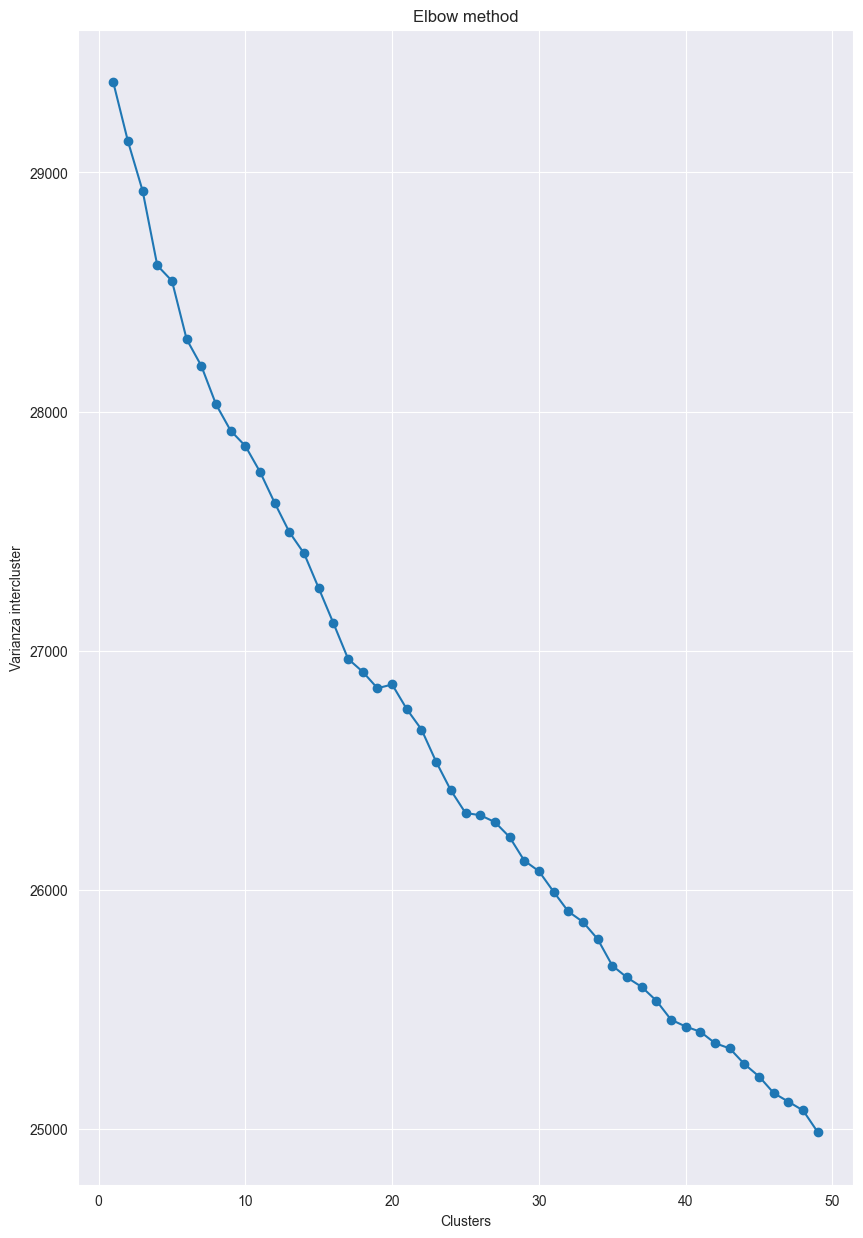

In [148]:
df['item_preprocesado'] = df['ITE_ITEM_TITLE'].apply(preprocessing)

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['item_preprocesado'])

tfidf_matrix = normalize(tfidf_matrix)

varianzas = []
rangos_clusters = range(1, 50)

for num_clusters in rangos_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(tfidf_matrix)
    varianzas.append(kmeans.inertia_)

plt.figure(figsize=(10, 15))
plt.plot(rangos_clusters, varianzas, marker='o')
plt.title('Elbow method')
plt.xlabel('Clusters')
plt.ylabel('Varianza intercluster')
plt.show()

4, 17 y 25 parecen ser candidatos.

In [149]:
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

In [150]:
for cluster in range(num_clusters):
    display(df[df['cluster'] == cluster])

,ITE_ITEM_TITLE,item_preprocesado,cluster
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve,inteligente led bicicleta tauda luz usb bicicleta carregave,0
16,Bicicleta Masculina Com Aro 24 Com Nf,bicicleta masculina aro nf,0
28,Caiçara Cargo 80 Bicicleta Motorizada Suspensão Freio Adisco,caicara cargo bicicleta motorizada suspensao freio adisco,0
52,Antiga Bicicleta Caloi Cross Freestyle,antiga bicicleta caloi cross freestyle,0
54,Bicicleta Sonic Aro 12 - 4 Itens,bicicleta sonic aro itens,0
...,...,...,...
29876,Bicicleta Gts Aro 29 Full Carbono 1x12 Sram | Gts Rav Gold,bicicleta gts aro full carbono sram gts rav gold,0
29932,Bicicleta Aro 29 Mtb Milano One Alumínio 24v Disco Azul,bicicleta aro mtb milano one aluminio disco azul,0
29937,Bicicleta Nautec Alumínio Aro 26,bicicleta nautec aluminio aro,0
29978,Fucsia Aro 12 Bicicleta - 10440,fucsia aro bicicleta,0


,ITE_ITEM_TITLE,item_preprocesado,cluster
6,Tênis Infantil Ortopasso Conforto Jogging,tenis infantil ortopasso conforto jogging,1
11,Sapatenis Casual Combo 3 Pares Infantil Dex,sapatenis casual combo pares infantil dex,1
14,Tênis Molekinha Chunky Flatform Infantil Sem Cadarço Menina,tenis molekinha chunky flatform infantil cadarco menina,1
15,Tênis Infantil Feminino Kidy Hype Nude,tenis infantil feminino kidy hype nude,1
51,Tenis Infantil Preto Molekinho/ Dia Das Crianças,tenis infantil preto dia criancas,1
...,...,...,...
29953,Tênis Menino Menina Infantil Escolar Audax A2402 Promoção,tenis menino menina infantil escolar audax promocao,1
29954,Tenis Calce Facil Infantil Feminino E Masculino Para Revenda,tenis calce facil infantil feminino masculino revenda,1
29960,Tênis Infantil Sem Cadarço Bibi Roller Newrln-47 Vi Original,tenis infantil cadarco bibi roller vi original,1
29966,Tenis Botinho Infantil Cano Alto - B677 Novo,tenis botinho infantil cano alto,1


,ITE_ITEM_TITLE,item_preprocesado,cluster
0,Tênis Ascension Posh Masculino - Preto E Vermelho,tenis ascension posh masculino preto vermelho,2
1,Tenis Para Caminhada Super Levinho Spider Corrida,tenis caminhada super levinho spider corrida,2
2,Tênis Feminino Le Parc Hocks Black/ice Original Envio Já,tenis feminino le parc hocks original envio ja,2
3,Tênis Olympikus Esportivo Academia Nova Tendência Triunfo,tenis olympikus esportivo academia tendencia triunfo,2
5,Tênis Casual Masculino Zarato 941 Preto 632,tenis casual masculino zarato preto,2
...,...,...,...
29989,Tênis Ykes F5,tenis ykes,2
29991,Ténis Running Para Corrida Masculino Treino Esportivo,tenis running corrida masculino treino esportivo,2
29992,Tênis Nike Zoom Javelin Elite,tenis nike zoom javelin elite,2
29994,Air Force Shadow Mystic Navy,air force shadow mystic navy,2


,ITE_ITEM_TITLE,item_preprocesado,cluster
12,Kit Tênis Slip Feminino Com Mochila Grande E Máscara Black,kit tenis slip feminino mochila mascara black,3
17,Tenis Feminino Pimenta Doce Plataforma Chunky Sneaker,tenis feminino pimenta doce plataforma chunky sneaker,3
21,Tenis Feminino De Fazer Caminhada Corrida Academia Barato,tenis feminino caminhada corrida academia barato,3
22,Tenis Feminino Casual Blogueira Juliette Plataforma,tenis feminino casual blogueira juliette plataforma,3
27,Tênis Via Marte Juliete Bbb Feminino Cor Branco,tenis via marte juliete bbb feminino cor branco,3
...,...,...,...
29990,Tênis adidas Lite Racer 2.0 Feminino Preto Original + Nfe,tenis adidas lite racer feminino preto original nfe,3
29993,Tênis Feminino Dakota Kicks G0984,tenis feminino dakota kicks,3
29996,Tênis Feminino Preto Moleca 5296155,tenis feminino preto moleca,3
29997,Tenis Botinha Com Pelo Via Marte Original Lançamento,tenis botinha via marte original lancamento,3


In [169]:
for cluster in range(num_clusters):
    print(list(df[df['cluster'] == cluster]['ITE_ITEM_TITLE']))
    print("\n\n\n")

['Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve', 'Bicicleta Masculina Com Aro 24 Com Nf ', 'Caiçara Cargo 80 Bicicleta Motorizada Suspensão Freio Adisco', 'Antiga Bicicleta Caloi Cross Freestyle', 'Bicicleta Sonic Aro 12 - 4 Itens', 'Bicicleta Infantil Kls Blue Girls Aro 16 Rodas De Nylon', 'Bicicleta Nathor Aro 12 Infantil Cores Masculina Feminina ', 'Bicicleta Aro 12 Feminina Infantil Nathor Violet Promoção', 'Bicicleta Aro 29 Rs1 Pro 24v Freio Hidra Trava Cinza 17', 'Bicicleta Gts Pro M5 Techs 21v Aro 29 Freio À Disco Aluminio', 'Bicicleta Sense Grom 2021 - Aro 16', 'Bicicleta Aro 26 Caloi Andes V-brake 21 Marchas Quadro Aço', 'Bicicleta Aro 29 Gta De Alumínio 21 Marcha.', 'Bicicleta Infantil Aro 20 Com Pezinho Mini Antonella Rosa ', 'Bicicleta 29 Dropp Z3 Kit Absolut 12v Hidráulic Trava Guida', 'Bicicleta Freeride Passeio Viking 21v Aro 26 - Azul Claro', 'Bicicleta Aro29 Z1-x Q19 Freio Disco Mecânico 21v Azul Dropp', 'Bicicleta Aro 20 Tipo Poti Com  Cesta Feminino 5 

In [170]:
num_clusters = 17
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

In [171]:
for cluster in range(num_clusters):
    display(df[df['cluster'] == cluster])

,ITE_ITEM_TITLE,item_preprocesado,cluster
8,Tênis Usthemp Short Temático - Maria Vira-lata 2,tenis usthemp short tematico maria,0
12,Kit Tênis Slip Feminino Com Mochila Grande E Máscara Black,kit tenis slip feminino mochila mascara black,0
13,adidas Superstar Run Dmc,adidas superstar run dmc,0
19,Tênis Actvitta Sevilha Preto,tenis actvitta sevilha preto,0
20,Tênis Super Star Caminhada Estilo Casual Marinho Unissex +nf,tenis super star caminhada estilo casual marinho unissex,0
...,...,...,...
29985,Mizuno Wave Prophecy Hajime Sorayama,mizuno wave prophecy hajime sorayama,0
29989,Tênis Ykes F5,tenis ykes,0
29992,Tênis Nike Zoom Javelin Elite,tenis nike zoom javelin elite,0
29994,Air Force Shadow Mystic Navy,air force shadow mystic navy,0


,ITE_ITEM_TITLE,item_preprocesado,cluster
1,Tenis Para Caminhada Super Levinho Spider Corrida,tenis caminhada super levinho spider corrida,1
21,Tenis Feminino De Fazer Caminhada Corrida Academia Barato,tenis feminino caminhada corrida academia barato,1
30,Tênis Fila Masculino Preto Corrida Caminhada Academia,tenis fila masculino preto corrida caminhada academia,1
55,Tênis Feminino Caminhada Original Mikelly Confortável Azul,tenis feminino caminhada original mikelly confortavel azul,1
64,Tênis Leve Fila Racer Motion Academia Caminhada,tenis leve fila racer motion academia caminhada,1
...,...,...,...
29813,Tenis Feminino Casual Caminhada Plataform Promoção Original,tenis feminino casual caminhada plataform promocao original,1
29855,Tênis Maculino Academia Caminhada P/ Pratica Esporte Oferta,tenis maculino academia caminhada pratica esporte oferta,1
29858,Tênis Masculino Caminhada Pegasus Casual Leve E Confortável,tenis masculino caminhada pegasus casual leve confortavel,1
29917,Tênis Esportivo Masculino Em Nylon Caminhada Confortável,tenis esportivo masculino nylon caminhada confortavel,1


,ITE_ITEM_TITLE,item_preprocesado,cluster
6,Tênis Infantil Ortopasso Conforto Jogging,tenis infantil ortopasso conforto jogging,2
130,Molekinha Tênis Conforto Antiderrapante 012870,molekinha tenis conforto antiderrapante,2
133,Tenis Chunky Kolosh Feminino Casual Evafit Conforto Maciez,tenis chunky kolosh feminino casual evafit conforto maciez,2
194,Tênis Infantil Menino Esportivo Conforto Molekinho Cinza,tenis infantil menino esportivo conforto molekinho cinza,2
454,Tênis Corrida Masculino Leveza Estabilidade Conforto Total,tenis corrida masculino leveza estabilidade conforto total,2
...,...,...,...
29878,Tênis Sapatênis Masculino Casual Original Conforto Promoção,tenis sapatenis masculino casual original conforto promocao,2
29882,"Tênis Campesi Feminino,joanete Conforto Azul Promoção(c/nf)",tenis campesi feminino joanete conforto azul promocao,2
29921,Usaflex Tênis Extra Conforto Anatômica Ad1803,usaflex tenis extra conforto anatomica,2
29927,Sapatenis Casual Masculino Sport Conforto Macio Preço Baixo,sapatenis casual masculino sport conforto macio preco,2


,ITE_ITEM_TITLE,item_preprocesado,cluster
4,Inteligente Led Bicicleta Tauda Luz Usb Bicicleta Carregáve,inteligente led bicicleta tauda luz usb bicicleta carregave,3
16,Bicicleta Masculina Com Aro 24 Com Nf,bicicleta masculina aro nf,3
28,Caiçara Cargo 80 Bicicleta Motorizada Suspensão Freio Adisco,caicara cargo bicicleta motorizada suspensao freio adisco,3
52,Antiga Bicicleta Caloi Cross Freestyle,antiga bicicleta caloi cross freestyle,3
54,Bicicleta Sonic Aro 12 - 4 Itens,bicicleta sonic aro itens,3
...,...,...,...
29876,Bicicleta Gts Aro 29 Full Carbono 1x12 Sram | Gts Rav Gold,bicicleta gts aro full carbono sram gts rav gold,3
29932,Bicicleta Aro 29 Mtb Milano One Alumínio 24v Disco Azul,bicicleta aro mtb milano one aluminio disco azul,3
29937,Bicicleta Nautec Alumínio Aro 26,bicicleta nautec aluminio aro,3
29978,Fucsia Aro 12 Bicicleta - 10440,fucsia aro bicicleta,3


,ITE_ITEM_TITLE,item_preprocesado,cluster
0,Tênis Ascension Posh Masculino - Preto E Vermelho,tenis ascension posh masculino preto vermelho,4
2,Tênis Feminino Le Parc Hocks Black/ice Original Envio Já,tenis feminino le parc hocks original envio ja,4
5,Tênis Casual Masculino Zarato 941 Preto 632,tenis casual masculino zarato preto,4
44,Tênis Masculino Esportivo Actvitta 4907.101,tenis masculino esportivo actvitta,4
45,Tênis Nike Court Vision Low Premium Mtz Original + Nfe,tenis nike court vision low premium mtz original nfe,4
...,...,...,...
29956,Combo 3 Ténis Masculino Feminino Linha Evoltenn Treino,combo tenis masculino feminino linha evoltenn treino,4
29973,Tênis D&c Shoes Skatista Original! 39/40 Novo !,tenis d c shoes skatista original,4
29977,Tênis Nike Original Brasil,tenis nike original brasil,4
29990,Tênis adidas Lite Racer 2.0 Feminino Preto Original + Nfe,tenis adidas lite racer feminino preto original nfe,4


,ITE_ITEM_TITLE,item_preprocesado,cluster
42,Tenis De Menino Bota Com Luz De Led Sapato Preto Verde Barat,tenis menino bota luz led sapato preto verde barat,5
188,Tênis Sapato Short Bermuda Combo Promoção Lançamento,tenis sapato short bermuda combo promocao lancamento,5
244,Sapatenis Casual Masculino 2 Pares Tenis Sapato Confort,sapatenis casual masculino pares tenis sapato confort,5
360,Sapato Infantil Social Tênis Escolar Aniversário Festa Luxo,sapato infantil social tenis escolar aniversario festa luxo,5
383,Tênis Sapato Slip-on Coração Vermelho Exclusivo Novidade Top,tenis sapato coracao vermelho exclusivo novidade top,5
...,...,...,...
29565,Sapato Boneca (sistema Comfort) Em Couro Nr.35 Cod. Lm 470a,sapato boneca comfort couro cod lm,5
29712,Tenis Infantil Rosa Festa Aniversario Moda Menina Sapato,tenis infantil rosa festa aniversario moda menina sapato,5
29753,Sapato Footjoy Leisure Golf - Feminino,sapato footjoy leisure golf feminino,5
29762,Sapato Masculino Ferracini Couro Natural 7172-607a Preto,sapato masculino ferracini couro natural preto,5


,ITE_ITEM_TITLE,item_preprocesado,cluster
11,Sapatenis Casual Combo 3 Pares Infantil Dex,sapatenis casual combo pares infantil dex,6
61,Sapatênis Ferricelli Com Zíper Tam 39,sapatenis ferricelli ziper tam,6
79,Tênis 02 Pares Sapatênis Sapatilha Casual Feminino Srt/414,tenis pares sapatenis sapatilha casual feminino,6
90,Sapatênis Samello Masculino Marrom 41,sapatenis samello masculino marrom,6
92,Kit 2 Pares Tênis Casual Sapatenis Feminino Clássico,kit pares tenis casual sapatenis feminino classico,6
...,...,...,...
29951,Sapatênis Masculino Confort Plus Yate Viena Babuche Novo,sapatenis masculino confort plus yate viena babuche,6
29967,Sapatênis Masculino Pegada Nobuck Gelo 100%original Promoção,sapatenis masculino pegada nobuck gelo original promocao,6
29975,Tenis Feminino Casual Sapatenis Feminino A Full,tenis feminino casual sapatenis feminino full,6
29976,Sapatênis Osklen Original,sapatenis osklen original,6


,ITE_ITEM_TITLE,item_preprocesado,cluster
7,Tv Samsung Qled 8k Q800t Semi Nova,tv samsung qled semi,7
18,Smart Tv Led 40 Philco Ptv40e60sn Full Hd Conversor Digital,smart tv led philco full hd conversor digital,7
104,Placa De Comando (power)+ Sensor Tv Lg39ln5400,placa comando power sensor tv,7
171,Tv Digital Portátil 14 Polegadas Led Monitor Hd Hdmi Usb Sd Vga Mtm1410,tv digital portatil polegadas led monitor hd hdmi usb sd vga,7
318,Tv De Plasma LG 42pn4600 - Tv Não Liga Vendo Ela Inteira,tv plasma lg tv nao liga vendo inteira,7
...,...,...,...
29678,Smart Tv LG 65'' 4k Nanocell 65nano75 Thinq Ai Smart Magic,smart tv lg nanocell thinq ai smart magic,7
29732,Oferta Smart Tv Samsung Led 4k 85 100v/240v,oferta smart tv samsung led,7
29958,Tv 42 Pol Led LG,tv pol led lg,7
29974,Tv Semp-toshiba 10 - Antiga - Sucata,tv antiga sucata,7


,ITE_ITEM_TITLE,item_preprocesado,cluster
60,Ténis Estilo All Star Cano Alto Masculino De Couro 16,tenis estilo all star cano alto masculino couro,8
117,Tenis Infantil Menino Menina Cano Alto Bota Botinha Tênis,tenis infantil menino menina cano alto bota botinha tenis,8
129,Tênis All Star Converse Cor Branco Cano Baixo - 379,tenis all star converse cor branco cano,8
140,Tenis Feminino Star Rosa Cano Baixo Converse 1,tenis feminino star rosa cano converse,8
162,Tênis Feminino Cano Alto Star Lona Botinha Contramão,tenis feminino cano alto star lona botinha contramao,8
...,...,...,...
29888,Tênis Casual Cano Baixo Masculino Original Promoção!!!,tenis casual cano masculino original promocao,8
29903,Tenis Cano Alto Polo +boné Original +relógio Preto +ócul,tenis cano alto polo original preto,8
29944,Tenis Cano Alto Feminino Botinha Preto Zíper,tenis cano alto feminino botinha preto ziper,8
29966,Tenis Botinho Infantil Cano Alto - B677 Novo,tenis botinho infantil cano alto,8


,ITE_ITEM_TITLE,item_preprocesado,cluster
9,Sapatênis West Coast Urban Couro Masculino,sapatenis west coast urban couro masculino,9
77,Tênis Casual Intruder Max Confort Plus Couro Marrom,tenis casual intruder max confort plus couro marrom,9
190,Sapatênis Masculino Pegada Em Couro 118107 Amortech Original,sapatenis masculino pegada couro amortech original,9
200,Tênis Lilica Ripilica Original Em Couro,tenis lilica ripilica original couro,9
205,Tênis Ous Ueno Refletivo Essencial Couro Preto 350004-11 Nf,tenis ous ueno refletivo essencial couro preto nf,9
...,...,...,...
29948,Tênis Caterpillar Couro Legítimo Corrida Urbano Academia,tenis caterpillar couro legitimo corrida urbano academia,9
29963,Sapatênis Couro Pegada Marrom E Preto Masculino 119301,sapatenis couro pegada marrom preto masculino,9
29965,Sapatênis Masculino Marca Pegada 100% Couro Ref: 117408-05,sapatenis masculino marca pegada couro ref,9
29982,"256 Sapatênis Marrom, Confeccionado Em Couro",sapatenis marrom confeccionado couro,9


,ITE_ITEM_TITLE,item_preprocesado,cluster
29,Tênis Vizzano Slip On Monograma,tenis vizzano slip on monograma,10
72,Slip On Feminino Calce Facil Moleca Original Tenis Casual,slip on feminino calce facil moleca original tenis casual,10
73,Tenis Slip On Masculino Couro Legítimo Casual Lindo,tenis slip on masculino couro legitimo casual lindo,10
177,Tênis Flatform Slip On Pérolas Napa Rosa 145666b,tenis flatform slip on perolas napa rosa,10
255,Tênis Mule Feminino Sapatênis Slip On Confortável Anabela,tenis mule feminino sapatenis slip on confortavel anabela,10
...,...,...,...
29804,Iate Slip On Sapatilha Masculina Sportfire 0062,iate slip on sapatilha masculina sportfire,10
29849,Slip On Casual Feminino Liso Skid Grip Dk Shoes Promoção,slip on casual feminino liso skid grip dk shoes promocao,10
29881,Tênis Feminino Slip On,tenis feminino slip on,10
29939,Tênis Flat Slip On Sola Baixa C/ Glitter Carrano 111886,tenis flat slip on sola baixa glitter carrano,10


,ITE_ITEM_TITLE,item_preprocesado,cluster
27,Tênis Via Marte Juliete Bbb Feminino Cor Branco,tenis via marte juliete bbb feminino cor branco,11
209,Tênis Via Marte 217202,tenis via marte,11
428,Tênis Sneakear Via Marte Tye Die 2014907,tenis sneakear via marte tye die,11
429,Tenis Feminino Flatform Casual Nobuck Via Marte 21-10101,tenis feminino flatform casual nobuck via marte,11
433,Tênis Via Marte Chunky Sneaker Casual Feminino Promoção,tenis via marte chunky sneaker casual feminino promocao,11
...,...,...,...
29633,Sapatênis Femininio Cano Baixo Via Marte Estiloso Leve,sapatenis femininio cano via marte estiloso leve,11
29699,Tênis Feminino Via Marte Slip On Iate Calce 20-12407 Branco,tenis feminino via marte slip on iate calce branco,11
29916,Tênis Via Marte Soft Rose Branco 21-12004-01,tenis via marte soft rose branco,11
29971,Tênis Via Marte 11702 Branco.color,tenis via marte,11


,ITE_ITEM_TITLE,item_preprocesado,cluster
10,Sapatilha Bike Absolute Nero Mtb Para Pedal Clip Com Tacos,sapatilha bike absolute nero mtb pedal clip tacos,12
34,Sapatilha Mtb Bike Shiver Preta / Cinza,sapatilha mtb bike shiver preta cinza,12
62,Sapatilha Mtb Scott Comp Boa Verm/ Pto,sapatilha mtb scott comp pto,12
71,Tênis Neoprene Trilha Sapatilha Náutica Cores Unissex Top,tenis neoprene trilha sapatilha nautica cores unissex top,12
91,Sapatilha Com Pedal,sapatilha pedal,12
...,...,...,...
29900,Sapatilha Tsw Mtb Rocket,sapatilha tsw mtb rocket,12
29901,Sapatilha Road R4 Ciclismo Bike 42 Br Cinza Amarelo Neon,sapatilha road ciclismo bike br cinza amarelo neon,12
29902,Sapatilha Mtb Sh-xc100 Tam 46 Vmo,sapatilha mtb tam vmo,12
29906,Ténis Sapatilha Fechada Em Couro Promoção,tenis sapatilha fechada couro promocao,12


,ITE_ITEM_TITLE,item_preprocesado,cluster
23,Tênis Moleca Nude Com Corda 5674104,tenis moleca nude corda,13
76,Tênis Solado Baixo Moleca Feminino Camurça Original,tenis solado moleca feminino camurca original,13
257,Tênis Moleca Casual Branco 5605434,tenis moleca casual branco,13
280,Tênis Casual Feminino Moleca Napa Rosa 5731.205,tenis casual feminino moleca napa rosa,13
298,Tênis Casual Feminino Adulto Lona Moleca 5738.101,tenis casual feminino adulto lona moleca,13
...,...,...,...
29218,Tênis Casual Moleca,tenis casual moleca,13
29353,Tênis Feminino Moleca Plataforma Flatform Casual Social,tenis feminino moleca plataforma flatform casual social,13
29401,Tênis Feminino Dia A Dia Moleca Napa Lançamento Novidade!,tenis feminino dia dia moleca napa lancamento novidade,13
29512,Tênis Moleca Matelassê Costuras Feminino Marinho - 5605.207,tenis moleca matelasse costuras feminino marinho,13


,ITE_ITEM_TITLE,item_preprocesado,cluster
17,Tenis Feminino Pimenta Doce Plataforma Chunky Sneaker,tenis feminino pimenta doce plataforma chunky sneaker,14
22,Tenis Feminino Casual Blogueira Juliette Plataforma,tenis feminino casual blogueira juliette plataforma,14
31,Tenis Casual Preto Elastico,tenis casual preto elastico,14
35,Tênis Feminino Top Star Injetado Preto,tenis feminino top star injetado preto,14
36,Combo 2 Tênis Vivet Feminino Original A Pronta Entrega,combo tenis vivet feminino original pronta entrega,14
...,...,...,...
29950,Tênis Sneakers Chuncky Feminino Napa Onça Com Pink,tenis sneakers chuncky feminino napa onca pink,14
29961,Tênis Feminino Slipon Versátil Elástico Confortável,tenis feminino slipon versatil elastico confortavel,14
29970,Tenis Chunky Sneaker Casual Basico Feminino Sola Alta,tenis chunky sneaker casual basico feminino sola alta,14
29972,Tenis Feminino Ramarim Sneakers Chunky 20-72202 Original Nf,tenis feminino ramarim sneakers chunky original nf,14


,ITE_ITEM_TITLE,item_preprocesado,cluster
3,Tênis Olympikus Esportivo Academia Nova Tendência Triunfo,tenis olympikus esportivo academia tendencia triunfo,15
56,Tenis Infantil Olympikus Spider Kids,tenis infantil olympikus spider kids,15
67,Tênis Olympikus Pride 2 Feminino Verde E Rosa,tenis olympikus pride feminino verde rosa,15
78,Tênis Masculino Olympikus Absolute Esportivo Slipon Original,tenis masculino olympikus absolute esportivo slipon original,15
106,Tênis Olympikus Sonoro Masculino Treino E Academia 799,tenis olympikus sonoro masculino treino academia,15
...,...,...,...
29871,Tênis Olympikus Anyway Feminino Azul Marinho Original,tenis olympikus anyway feminino azul marinho original,15
29874,Tênis Olympikus Vetor / 787 Masculino Academia - Fitness,tenis olympikus vetor masculino academia fitness,15
29913,Tenis Wellness Olympikus /322 Pto/chm,tenis wellness olympikus,15
29920,Tênis Olympikus Venus Feminino - Preto,tenis olympikus venus feminino preto,15


,ITE_ITEM_TITLE,item_preprocesado,cluster
14,Tênis Molekinha Chunky Flatform Infantil Sem Cadarço Menina,tenis molekinha chunky flatform infantil cadarco menina,16
15,Tênis Infantil Feminino Kidy Hype Nude,tenis infantil feminino kidy hype nude,16
51,Tenis Infantil Preto Molekinho/ Dia Das Crianças,tenis infantil preto dia criancas,16
63,Tênis Infantil Menina Fashion Kids Moda Feminino Bebe N22,tenis infantil menina fashion kids moda feminino bebe,16
66,Tenis Infantil Tênis Feminino Brinde Bolsa B Fantástico,tenis infantil tenis feminino brinde bolsa b fantastico,16
...,...,...,...
29949,Tênis Infantil Masculino Juvenil Bebê Lançamento Fxb Inf,tenis infantil masculino juvenil bebe lancamento fxb inf,16
29953,Tênis Menino Menina Infantil Escolar Audax A2402 Promoção,tenis menino menina infantil escolar audax promocao,16
29954,Tenis Calce Facil Infantil Feminino E Masculino Para Revenda,tenis calce facil infantil feminino masculino revenda,16
29960,Tênis Infantil Sem Cadarço Bibi Roller Newrln-47 Vi Original,tenis infantil cadarco bibi roller vi original,16


La agrupación funciona mejor sin stemización, y de nuevo, a mayor cantidad de clusters, más literal es la agrupación, convirtiendosé ideal para un inventario de granularidad variable. Dominio adoptado: clusters pertenecientes a [17, 25]

- ## Conclusiones

Quedaron muchos algoritmos y preprocesamientos para probar. Sería interesante ver si la incorporación de embeddings con modelos pre-entrenados en portugues mejora el enfoque, como así también realizar un fine tunning de un modelo ya existente. La elección de librerías como Spacy y NLTK facilitan implementaciones sencillas de NLP, en conjunto. La elección de TFID para la POC fue debido a que es una herramienta potente y fácil de implementar en simples pasos.